# Tutorial: A General-Purpose, Multi-Metric Photon Geodesic Integrator

## Author: Dalton Moone

## This notebook constructs a complete C-language project that numerically integrates the path of a photon in various spacetimes. The project is designed to be a flexible ray-tracing engine, capable of generating lensed images of distant sources as seen by an observer near a black hole.

The core of the project is the numerical solution of the geodesic equation, which describes the path of a free-falling particle (or photon) through curved spacetime. The geodesic equation, as detailed on [Wikipedia](https://en.wikipedia.org/wiki/Geodesic_equation), is a second-order ordinary differential equation (ODE) that relates a particle's acceleration to the spacetime curvature, represented by the Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$):

$$ \frac{d^2x^{\alpha}}{d\lambda^2} = -\Gamma^{\alpha}_{\mu\nu} \frac{dx^{\mu}}{d\lambda} \frac{dx^{\nu}}{d\lambda} $$

To solve this numerically, we first convert it into a system of coupled first-order ODEs. This is a standard technique that makes the problem compatible with common ODE integrators like the GNU Scientific Library (GSL). We introduce the **pseudo-momentum**, $p^{\alpha}$, defined as the velocity with respect to an affine parameter $\lambda$:

$$ p^{\alpha} \equiv \frac{dx^{\alpha}}{d\lambda} $$

This splits the geodesic equation into a system of two first-order ODEs, which describes the path of a photon moving *forward* in time (`λ` increasing):

1.  **Forward Position ODE**: $ \frac{dx^{\alpha}}{d\lambda} = p^{\alpha} $
2.  **Forward Momentum ODE**: $ \frac{dp^{\alpha}}{d\lambda} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $

### The Reverse Ray-Tracing Transformation

To render an image of what an observer sees, we must trace the photon's path from the observer *backwards in time* to its source. While we could integrate with `dλ < 0`, most ODE solvers are designed to integrate forward with a positive step. To accommodate this, we perform a change of variables. We define a new affine parameter, $\kappa$, that increases as the original parameter, $\lambda$, decreases:

$$ \kappa = -\lambda \implies d\kappa = -d\lambda \implies \frac{d}{d\lambda} = -\frac{d}{d\kappa} $$

We now substitute this into our forward-time ODE system to find the new equations for a reversed trajectory, which will be integrated with a positive `dκ`:

*   **Reverse Position ODE**:
    $$ \frac{dx^{\alpha}}{d\lambda} = p^{\alpha} \implies \left(-\frac{d}{d\kappa}\right)x^{\alpha} = p^{\alpha} \implies \boxed{\frac{dx^{\alpha}}{d\kappa} = -p^{\alpha}} $$

*   **Reverse Momentum ODE**:
    $$ \frac{dp^{\alpha}}{d\lambda} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} \implies \left(-\frac{d}{d\kappa}\right)p^{\alpha} = -\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} \implies \boxed{\frac{dp^{\alpha}}{d\kappa} = +\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}} $$

This gives us the final set of equations that our C code will solve. We also add a third ODE to track the total proper distance traveled by the photon along its path:

1.  **Position ODE**: $\frac{dx^{\alpha}}{d\kappa} = -p^{\alpha}$
2.  **Momentum ODE**: $\frac{dp^{\alpha}}{d\kappa} = +\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$
3.  **Path Length ODE**: $\frac{dL}{d\kappa} = \sqrt{g_{ij}p^{i}p^{j}}$

This notebook follows a modular, single-responsibility design pattern. It uses the `nrpy` library to first define the underlying physics symbolically, and then automatically generates a series of interoperable C functions, each with a specific job. This makes the final C project clear, efficient, and easily extensible to new spacetime metrics like Kerr.

**Notebook Status:** <font color='green'><b>Validated</b></font>

# Table of Contents

This notebook is organized into a series of logical steps, with each core Python function encapsulated in its own cell. This modular design enhances readability and maintainability.

1.  [Step 1: Project Initialization](#initialize)
2.  [Step 2: The Symbolic Core - Foundational Math](#symbolic_core)
    1.  [2.a: Metric Tensor Derivatives](#deriv_g4DD)
    2.  [2.b: Christoffel Symbol Calculation](#four_connections)
    3.  [2.c: Geodesic Momentum RHS](#geodesic_mom_rhs)
    4.  [2.d: Geodesic Position RHS](#geodesic_pos_rhs)
    5.  [2.e: Proper Length ODE RHS](#proper_len_rhs)
    6.  [2.f: Symbolic Calculation of p⁰](#geodesic_mom0_calc)
3.  [Step 3: Spacetime Definitions and Symbolic Execution](#spacetime_and_execution)
    1.  [3.a: The Schwarzschild Metric](#schwarzschild_metric)
    2.  [3.b: The Kerr Metric](#kerr_metric)
    3.  [3.c: Symbolic Workflow Execution](#symbolic_execution)
4.  [Step 4: C Code Generation - Physics "Engines"](#generate_c_engines)
    1.  [4.a: `con_schwarzschild()` Worker](#con_schwarzschild_engine)
    2.  [4.b: `con_kerr()` Worker](#con_kerr_engine)
    3.  [4.c: `g4DD_schwarzschild()` Worker](#g4DD_schwarzschild_engine)
    4.  [4.d: `g4DD_kerr()` Worker](#g4DD_kerr_engine)
    5.  [4.e: `calculate_p0()` Engine](#calculate_p0_engine)
    6.  [4.f: `calculate_ode_rhs()` Engine](#calculate_ode_rhs_engine)
    7.  [4.g: `lagrange_interp_engine()` Engine](#lagrange_interp_engine)
5.  [Step 5: C Code Generation - Dispatchers and Orchestrators](#generate_c_orchestrators)
    1.  [5.a: `connections()` Dispatcher](#connections_dispatcher)
    2.  [5.b: `g4DD_metric()` Dispatcher](#g4DD_metric_dispatcher)
    3.  [5.c: `initial_data()` Orchestrator (for debugging)](#initial_data_orchestrator)
    4.  [5.d: `set_initial_conditions_for_ray()` Orchestrator](#set_initial_conditions_for_ray)
    5.  [5.e: The GSL Wrapper Function](#gsl_wrapper)
    6.  [5.f: The Main Integration Loop](#integration_loop)
    7.  [5.g: The `main()` C Function Entry Point](#main_entry_point)
6.  [Step 6: Project Assembly](#assemble_project)
    1.  [6.a: Custom Data Structures](#register_structs)
    2.  [6.b: Final Build and Compilation](#final_build)
7.  [Step 7: Plotting and Visualization](#plotting)
    1.  [7.a: 3D Trajectory Plotter](#plot_3d)
    2.  [7.b: Image Renderer](#plot_image)

<a id='initialize'></a>
# Step 1: Project Initialization

This cell sets up the foundational elements for our entire project. It performs three key tasks:

1.  **Import Libraries**: We import necessary modules from standard Python libraries (`os`, `shutil`, `sympy`) and the core components of `nrpy`. The `nrpy` imports provide tools for C function registration (`nrpy.c_function`), C code generation (`nrpy.c_codegen`), parameter handling (`nrpy.params`), and infrastructure management from `nrpy.infrastructures.BHaH`.

2.  **Directory Management**: A clean output directory, `project/photon_geodesic_integrator/`, is created to store the generated C code, ensuring a fresh build every time the notebook is run.

3.  **Physical Parameter Definition**: We define several physical and runtime parameters using `nrpy.params.CodeParameter`. This powerful object registers each parameter with the BHaH infrastructure, allowing it to be set at runtime via a parameter file (`.par`) or command-line arguments. We use several flags to control its behavior:
    *   `commondata=True`: Specifies that the parameter is "common" to the entire simulation (e.g., black hole mass `M_scale`, spin `a_spin`). It will be stored in the `commondata_struct` in the generated C code.
    *   `add_to_parfile=True`: Instructs the build system to add an entry for this parameter to a default parameter file, making it easy to configure.
    *   `add_to_set_CodeParameters_h=True`: This is a crucial flag that enables the "automatic unpacking" mechanism, also known as the "Triple-Lock". It tells `nrpy` to add an entry for the parameter to the `set_CodeParameters.h` convenience header. Any C function registered with `include_CodeParameters_h=True` will get a local `const REAL` variable with the same name as the parameter, making the C code clean and readable. This is handled by the `nrpy.infrastructures.BHaH.CodeParameters` module.

In [1]:
# Cell ID: 33f07e1c (Replacement)

import os
import shutil
import sympy as sp

# NRPy-related imports for C-code generation
import nrpy.c_function as cfc
import nrpy.c_codegen as ccg
import nrpy.params as par
import nrpy.indexedexp as ixp
import nrpy.infrastructures.BHaH.BHaH_defines_h as Bdefines_h
import nrpy.infrastructures.BHaH.Makefile_helpers as Makefile
from nrpy.infrastructures.BHaH import cmdline_input_and_parfiles
import nrpy.helpers.generic as gh
import nrpy.infrastructures.BHaH.CodeParameters as CPs


# Set project name and clean the output directory
project_name = "photon_geodesic_integrator"
project_dir = os.path.join("project", project_name)
shutil.rmtree(project_dir, ignore_errors=True)

# Set NRPy parameters for the BHaH infrastructure
par.set_parval_from_str("Infrastructure", "BHaH")

# --- Universal Camera System Parameters ---
camera_pos_x = par.CodeParameter("REAL", __name__, "camera_pos_x", 21.0, add_to_parfile=True, commondata=True)
camera_pos_y = par.CodeParameter("REAL", __name__, "camera_pos_y", 0.0,  add_to_parfile=True, commondata=True)
camera_pos_z = par.CodeParameter("REAL", __name__, "camera_pos_z", 0.0,  add_to_parfile=True, commondata=True)

window_center_x = par.CodeParameter("REAL", __name__, "window_center_x", 20.0, add_to_parfile=True, commondata=True)
window_center_y = par.CodeParameter("REAL", __name__, "window_center_y", 0.0,  add_to_parfile=True, commondata=True)
window_center_z = par.CodeParameter("REAL", __name__, "window_center_z", 0.0,  add_to_parfile=True, commondata=True)

# --- Independent Source Plane Definition ---
source_plane_normal_x = par.CodeParameter("REAL", __name__, "source_plane_normal_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_y = par.CodeParameter("REAL", __name__, "source_plane_normal_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_normal_z = par.CodeParameter("REAL", __name__, "source_plane_normal_z", 1.0, add_to_parfile=True, commondata=True)

source_plane_center_x = par.CodeParameter("REAL", __name__, "source_plane_center_x", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_y = par.CodeParameter("REAL", __name__, "source_plane_center_y", 0.0, add_to_parfile=True, commondata=True)
source_plane_center_z = par.CodeParameter("REAL", __name__, "source_plane_center_z", 0.0, add_to_parfile=True, commondata=True)

source_up_vec_x = par.CodeParameter("REAL", __name__, "source_up_vec_x", 0.0, add_to_parfile=True, commondata=True)
source_up_vec_y = par.CodeParameter("REAL", __name__, "source_up_vec_y", 0.0, add_to_parfile=True, commondata=True)
source_up_vec_z = par.CodeParameter("REAL", __name__, "source_up_vec_z", 1.0, add_to_parfile=True, commondata=True) 

# --- General Ray-Tracing Parameters ---
scan_density = par.CodeParameter("int", __name__, "scan_density", 512, add_to_parfile=True, commondata=True)
window_size = par.CodeParameter(
    "REAL", __name__, "window_size", 2.0, 
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

# --- Physical Parameters ---
M_scale = par.CodeParameter(
    "REAL", __name__, "M_scale", 1.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)
a_spin = par.CodeParameter(
    "REAL", __name__, "a_spin", 0.0,
    add_to_parfile=True, commondata=True, add_to_set_CodeParameters_h=True
)

<a id='symbolic_core'></a>
# Step 2: The Symbolic Core - Foundational Math

This section defines the pure mathematical logic of our problem using Python's `sympy` library. Each function in this section is a "blueprint" for a physical calculation. These functions take symbolic `sympy` objects as input and return new symbolic expressions as output. They have no knowledge of C code; they are concerned only with mathematics and will be called later to generate the "recipes" for our C code engines.

<a id='deriv_g4DD'></a>
### 2.a: Metric Tensor Derivatives

The first step in calculating the Christoffel symbols is to compute the partial derivatives of the metric tensor, $g_{\mu\nu}$. This function, `derivative_g4DD`, takes the symbolic 4x4 metric tensor `g4DD` and a list of the four coordinate symbols `xx` as input.

It initializes a storage container for the results using a helper function from `nrpy`'s `indexedexp` module, which can be found in `nrpy/indexedexp.py`:
*   **`ixp.zerorank3(dimension=4)`**: This function creates a symbolic rank-3 tensor (a Python list of lists of lists) of a specified dimension, with all elements initialized to the `sympy` integer 0.

The function then iterates through all components to symbolically calculate the partial derivative of each metric component with respect to each coordinate. The resulting quantity, which we can denote using comma notation as $g_{\mu\nu,\alpha}$, is defined as:

$$ g_{\mu\nu,\alpha} \equiv \frac{\partial g_{\mu\nu}}{\partial x^{\alpha}} $$

The nested `for` loops in the code directly correspond to the spacetime indices `μ, ν, α` in the physics equation. `sympy`'s built-in `sp.diff()` function is used to perform the symbolic differentiation, and the final result is returned as a rank-3 symbolic tensor.

In [2]:
def derivative_g4DD(g4DD, xx):
    """Computes the symbolic first derivatives of the metric tensor."""
    g4DD_dD = ixp.zerorank3(dimension=4)
    for nu in range(4):
        for mu in range(4):
            for alpha in range(4):
                g4DD_dD[nu][mu][alpha] = sp.diff(g4DD[nu][mu], xx[alpha])
    return g4DD_dD

<a id='four_connections'></a>
### 2.b: Christoffel Symbol Calculation

This function implements the core formula for the Christoffel symbols of the second kind, $\Gamma^{\delta}_{\mu\nu}$. It takes the symbolic metric tensor `g4DD` ($g_{\mu\nu}$) and its derivatives `g4DD_dD` ($g_{\mu\nu,\alpha}$) as input. The calculation requires the inverse metric, $g^{\mu\nu}$, which is computed using another `nrpy` helper function from `nrpy/indexedexp.py`:

*   **`ixp.symm_matrix_inverter4x4(g4DD)`**: This function takes a symbolic 4x4 symmetric matrix and analytically computes its inverse. It is highly optimized for this specific task, returning both the inverse matrix and its determinant.

The function then applies the well-known formula for the Christoffel symbols, which can be found on [Wikipedia](https://en.wikipedia.org/wiki/Christoffel_symbols#Christoffel_symbols_of_the_second_kind). Using the comma notation for partial derivatives, the formula is:

$$ \Gamma^{\delta}_{\mu\nu} = \frac{1}{2} g^{\delta\alpha} \left( g_{\nu\alpha,\mu} + g_{\mu\alpha,\nu} - g_{\mu\nu,\alpha} \right) $$

The Python `for` loops iterate over the spacetime indices `δ, μ, ν, α` to construct each component of the Christoffel symbol tensor. After the summation is complete, a series of `sympy` simplification functions are used. The pre-simplification steps `sp.collect()` and `sp.factor()` are particularly critical for complex metrics like Kerr, where they help guide the final, more expensive `sp.simplify()` to a correct and manageable result. The final, simplified rank-3 tensor of Christoffel symbols is then returned.

In [3]:
def four_connections(g4DD, g4DD_dD):
    """
    Computes and simplifies Christoffel symbols from the metric and its derivatives.
    
    This version includes sp.collect() and sp.factor() to help simplify the
    very large expressions that arise from the Kerr metric.
    """
    Gamma4UDD = ixp.zerorank3(dimension=4)
    g4UU, _ = ixp.symm_matrix_inverter4x4(g4DD)
    
    # Define the variables that appear in the complex denominators
    # We will collect expressions with respect to these.
    r, th = sp.symbols("y[1] y[2]", real=True)

    for mu in range(4):
        for nu in range(4):
            for delta in range(4):
                # Calculate the Christoffel symbol component using the standard formula
                for alpha in range(4):
                    Gamma4UDD[delta][mu][nu] += sp.Rational(1, 2) * g4UU[delta][alpha] * \
                        (g4DD_dD[nu][alpha][mu] + g4DD_dD[mu][alpha][nu] - g4DD_dD[mu][nu][alpha])
                
                # --- Pre-simplification Step for Robustness ---
                # Before the final, expensive simplification, we collect and factor.
                # This is especially important for the very large Kerr expressions.

                # 1. Collect terms with respect to r and cos(theta)
                expr = sp.collect(Gamma4UDD[delta][mu][nu], (r, sp.cos(th)))

                # 2. Factor the collected expression
                expr = sp.factor(expr)

                # 3. Now, perform the final simplification
                Gamma4UDD[delta][mu][nu] = sp.simplify(expr)

                 
    return Gamma4UDD

<a id='geodesic_mom_rhs'></a>
### 2.c: Geodesic Momentum RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the **pseudo-momentum**, $p^{\alpha}$. As established by our reverse ray-tracing derivation, this is the second of our three first-order ODE systems:
$$ \frac{dp^{\alpha}}{d\kappa} = +\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
where $p^{\mu}$ is the pseudo-momentum and $\kappa$ is the time-reversed affine parameter.

The function `geodesic_mom_rhs` takes the symbolic Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ as its input. It then defines the symbolic pseudo-momentum vector `pU` using `sympy`'s `sp.symbols()` function. Notice that we use "direct naming" here: the symbols are created with names that are already valid C array syntax (e.g., `y[4]`). This is a key `nrpy` technique that simplifies the final code generation by eliminating the need for string substitutions.

The core of this function constructs the symbolic expression for the RHS by performing the Einstein summation $\Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu}$. A direct implementation would involve a double loop over both $\mu$ and $\nu$ from 0 to 3, resulting in $4 \times 4 = 16$ terms for each of the four components of $\alpha$, which is computationally inefficient.

However, we can significantly optimize this calculation by exploiting symmetry. The term $p^{\mu} p^{\nu}$ is symmetric with respect to the interchange of the indices $\mu$ and $\nu$. The Christoffel symbols $\Gamma^{\alpha}_{\mu\nu}$ are also symmetric in their lower two indices. Therefore, the full sum can be split into diagonal ($\mu=\nu$) and off-diagonal ($\mu \neq \nu$) terms:
$$ \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + \sum_{\mu \neq \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The second sum over $\mu \neq \nu$ contains pairs of identical terms. For example, the term for $(\mu=1, \nu=2)$ is $\Gamma^{\alpha}_{12} p^{1} p^{2}$, and the term for $(\mu=2, \nu=1)$ is $\Gamma^{\alpha}_{21} p^{2} p^{1}$. Since $\Gamma^{\alpha}_{12} = \Gamma^{\alpha}_{21}$, these terms are the same. We can combine all such pairs by summing over only one of the cases (e.g., $\mu < \nu$) and multiplying by two:
$$ \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} = \sum_{\mu=0}^{3} \Gamma^{\alpha}_{\mu\mu} (p^{\mu})^2 + 2 \sum_{\mu < \nu} \Gamma^{\alpha}_{\mu\nu} p^{\mu} p^{\nu} $$
The Python code implements this optimized version. The outermost loop, `for alpha in range(4)`, iterates through each of the four components of the RHS vector we are constructing ($dp^0/d\kappa, dp^1/d\kappa, \dots$). Inside this, the loop `for mu in range(4)` handles the diagonal terms ($\Gamma^{\alpha}_{\mu\mu}(p^{\mu})^2$), and the innermost loop `for nu in range(mu + 1, 4)` handles the unique off-diagonal terms (where `nu > mu`), correctly multiplying them by 2. This structure ensures that each component $\alpha$ is computed with the minimum number of floating point operations, leading to more efficient C code.

In [4]:
def geodesic_mom_rhs(Gamma4UDD):
    """
    Symbolic RHS for momentum ODE: dp^a/dκ = -Γ^a_μν p^μ p^ν.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    geodesic_rhs = ixp.zerorank1(dimension=4)
    for alpha in range(4):
        for mu in range(4):
            geodesic_rhs[alpha] += Gamma4UDD[alpha][mu][mu] * pU[mu] * pU[mu]
            for nu in range(mu + 1, 4):
                geodesic_rhs[alpha] += 2 * Gamma4UDD[alpha][mu][nu] * pU[mu] * pU[nu]
        geodesic_rhs[alpha] = -geodesic_rhs[alpha]
    return geodesic_rhs

<a id='geodesic_pos_rhs'></a>
### 2.d: Geodesic Position RHS

This function defines the symbolic right-hand side (RHS) for the evolution of the position coordinates, $x^{\alpha}$. As derived from our reverse ray-tracing analysis, this is the first of our three first-order ODE systems:

$$ \frac{dx^{\alpha}}{d\kappa} = -p^{\alpha} $$

The Python function `geodesic_pos_rhs` is straightforward. It defines the components of the pseudo-momentum vector, `pU`, using `sympy`'s `sp.symbols()` function with the "direct naming" convention (`y[4]`, `y[5]`, etc.). It then simply returns a list containing the *negative* of each of these momentum components. This list of four symbolic expressions will serve as the first four components of the complete 9-component RHS vector that our C code will solve.

In [5]:
def geodesic_pos_rhs():
    """
    Symbolic RHS for position ODE: dx^a/dκ = p^a.
    p is the reverse-momentum, y[4]...y[7].
    """
    pt,pr,pth,pph = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU = [pt,pr,pth,pph]
    return pU

<a id='proper_len_rhs'></a>
### 2.e: Proper Length ODE RHS

This function defines the symbolic right-hand side for the evolution of the proper length, $L$. This is the final component of our ODE system and allows us to track the total distance the photon has traveled along its spatial path. The proper length element $dL$ is defined by the spatial part of the metric:

$$ dL^2 = g_{ij} dx^{i} dx^{j} $$

Dividing by $d\kappa^2$ and taking the square root gives us the rate of change of proper length with respect to our integration parameter $\kappa$:

$$ \frac{dL}{d\kappa} = \sqrt{g_{ij} \frac{dx^{i}}{d\kappa} \frac{dx^{j}}{d\kappa}} = \sqrt{g_{ij} (-p^i) (-p^j)} = \sqrt{g_{ij} p^{i} p^{j}} $$

The function `proper_lengh_rhs` symbolically implements the formula under the square root, $\sqrt{g_{ij} p^{i} p^{j}}$.
*   It declares a symbolic placeholder for the metric components, `metric->gij`, which will be provided by a C struct at runtime.
*   It uses `sympy` symbols for the spatial momentum components, `p^i`, (i.e., `y[5]`, `y[6]`, `y[7]`).
*   It programmatically constructs the optimized sum $g_{ij} p^{i} p^{j}$ using the same symmetry trick as the momentum RHS to reduce the number of terms.
*   Finally, it returns a single-element list containing the square root of this sum. This will be the 9th component (`rhs_out[8]`) of our ODE system.

In [6]:
def proper_lengh_rhs():
    p0,p1,p2,p3,L= sp.symbols("y[4] y[5] y[6] y[7] y[8]",Real=True)
    pU=[p0,p1,p2,p3] 

    g4DD=ixp.declarerank2("metric->g",dimension=4, sym="sym01")

    sum = sp.simplify(0)
    
    for i in range(1,4):
        sum += g4DD[i][i]*pU[i]*pU[i]

        for j in range(i+1,4):
            sum += 2*g4DD[i][j]*pU[i]*pU[j]

    sp.simplify(sum)

    return [sp.sqrt(sum)]


<a id='geodesic_mom0_calc'></a>
### 2.f: Symbolic Calculation of p⁰

To complete our initial data, we must enforce the **null geodesic condition**, which states that the squared 4-momentum of a photon is zero. This is because photons travel along null paths where the spacetime interval $ds^2$ is zero. This condition is expressed as:

$$ g_{\mu\nu} p^{\mu} p^{\nu} = 0 $$

Our goal is to solve this equation for the time-component of the pseudo-momentum, $p^0$. To do this, we must first expand the Einstein summation over the 4D spacetime indices (μ, ν = 0, 1, 2, 3) into separate time (`0`) and space (`i,j = 1,2,3`) components. The expansion yields:
$$ g_{00}(p^0)^2 + g_{0i}p^0 p^i + g_{i0}p^i p^0 + g_{ij}p^i p^j = 0 $$

Since the metric is symmetric ($g_{i0} = g_{0i}$), we can combine the middle terms:

$$ g_{00}(p^0)^2 + 2\left(\sum_{i=1}^3 g_{0i}p^i\right)p^0 + \left(\sum_{i,j=1}^3 g_{ij}p^i p^j\right) = 0 $$

This is a standard quadratic equation of the form $ax^2 + bx + c = 0$, where $x = p^0$. The coefficients are:
*   $a = g_{00}$
*   $b = 2 \sum_{i=1}^3 g_{0i}p^i$
*   $c = \sum_{i,j=1}^3 g_{ij}p^i p^j$

The solution for $p^0$ is given by the [quadratic formula](https://en.wikipedia.org/wiki/Quadratic_formula):

$$ p^0 = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} = \frac{1}{g_{00}} \left[ -\left(\sum g_{0i}p^i\right) \pm \sqrt{\left(\sum g_{0i}p^i\right)^2 - g_{00}\left(\sum g_{ij}p^i p^j\right)} \right] $$

We must choose the sign that results in a positive $p^0$, which corresponds to a **future-directed** photon (one moving forward in coordinate time). The function `mom_time()` below constructs the symbolic `sympy` expression for this formula.
*   It uses a helper function from the `nrpy.indexedexp` module, `ixp.declarerank2("g", ...)`, to create an abstract symbolic tensor for the metric components.
*   It then programmatically builds the summation terms and combines them according to the quadratic formula, returning a single, complex `sympy` expression. This expression is the "recipe" that our C code generator will use later.

In [7]:
def mom_time_p0_reverse():
    """
    Solves g_μν p^μ p^ν = 0 for our reverse-time momentum p^0.
    """
    p0,p1,p2,p3 = sp.symbols("y[4] y[5] y[6] y[7]", Real=True)
    pU=[p0,p1,p2,p3]
    g4DD = ixp.declarerank2("g", sym="sym01", dimension=4)
    sum_g0i_pi = sp.sympify(0)
    for i in range(1,4):
        sum_g0i_pi += g4DD[0][i]*pU[i]
    sum_gij_pi_pj = sp.sympify(0)
    for i in range(1,4):
        sum_gij_pi_pj += g4DD[i][i]*pU[i]*pU[i]
        for j in range(i+1,4):
            sum_gij_pi_pj += 2*g4DD[i][j]*pU[i]*pU[j]
    discriminant = sum_g0i_pi*sum_g0i_pi - g4DD[0][0]*sum_gij_pi_pj
    answer = (sum_g0i_pi + sp.sqrt(discriminant)) / g4DD[0][0]
    return answer

<a id='spacetime_and_execution'></a>
# Step 3: Spacetime Definitions and Symbolic Execution

This section marks the transition from defining abstract mathematical tools to applying them. We will now perform three key tasks:

1.  **Define a Specific Spacetime (Schwarzschild):** We will implement the Schwarzschild metric, which describes the geometry around a non-rotating, uncharged black hole. This provides the first specific `g_μν` that our abstract functions will operate on.
2.  **Define a Second Spacetime (Kerr):** We will implement the Kerr metric in Boyer-Lindquist coordinates, which describes a rotating, uncharged black hole. This demonstrates the multi-metric capability of the code.
3.  **Execute the Symbolic Workflow:** We will call the symbolic "blueprint" functions defined in Step 2 in the correct sequence for each metric. This will generate the final, complex `sympy` expressions for the Christoffel symbols, which are then stored in global Python variables, ready to be used by the C code generators in the subsequent steps.

<a id='schwarzschild_metric'></a>
### 3.a: The Schwarzschild Metric

This function defines the [Schwarzschild metric](https://en.wikipedia.org/wiki/Schwarzschild_metric) in spherical coordinates, which describes the spacetime geometry around a spherically symmetric, non-rotating, uncharged massive object.

The function first defines the symbolic coordinates for this spacetime ($t, r, \theta, \phi$) using `sympy`'s `sp.symbols()` function with the "direct naming" convention (`y[0], y[1], ...`). It then constructs the 4x4 metric tensor, $g_{\mu\nu}$, as a symbolic `sympy` matrix.

The non-zero components of the metric are:
$$ g_{tt} = -\left(1 - \frac{2M}{r}\right) \quad , \quad g_{rr} = \left(1 - \frac{2M}{r}\right)^{-1} \quad , \quad g_{\theta\theta} = r^2 \quad , \quad g_{\phi\phi} = r^2 \sin^2\theta $$

These components are constructed symbolically using the abstract `M_scale.symbol` to represent the mass of the black hole. The function returns the symbolic rank-2 tensor `g4DD_schw` ($g_{\mu\nu}$) and the Python list of coordinate symbols `xx_schw`.

In [8]:
def define_schwarzschild_metric_analytic():
    """Defines and returns the ANALYTIC Schwarzschild metric tensor and its coordinate system."""
    t, r, th, ph = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, r, th, ph]
    g4DD = ixp.zerorank2(dimension=4)
    
    M_sym = M_scale.symbol
    _1 = sp.sympify(1)
    _2 = sp.sympify(2)
    
    g4DD[0][0] = -(_1 - _2*M_sym/r)
    g4DD[1][1] = _1 / (_1 - _2*M_sym/r)
    g4DD[2][2] = r**2
    g4DD[3][3] = r**2 * sp.sin(th)**2
    return g4DD, xx


<a id='kerr_metric'></a>
### 3.b: The Kerr Metric

This function defines the [Kerr metric](https://en.wikipedia.org/wiki/Kerr_metric) in **Boyer-Lindquist coordinates**. This metric describes the geometry around a stationary, rotating, uncharged black hole and is characterized by both mass `M` and spin `a`.

The non-zero components are significantly more complex than in the Schwarzschild case and include an off-diagonal term `g_tφ` which couples time and azimuthal motion. This term is the mathematical origin of **frame-dragging**.

The function uses the symbolic parameters `M_scale.symbol` and `a_spin.symbol` to construct the metric components. The standard intermediate variables `ρ²` and `Δ` are used for compactness:
*   `ρ² = r² + a²cos²θ`
*   `Δ = r² - 2Mr + a²`

The function returns the symbolic rank-2 tensor `g4DD_kerr` and the list of coordinate symbols `xx_kerr`. This symbolic recipe will be used to generate both the C code for the metric itself and for its Christoffel symbols.

In [9]:
def define_kerr_schild_metric_analytic():
    """
    Defines and returns the Kerr metric tensor in Boyer-Lindquist coordinates.
    
    This is the standard form of the Kerr metric used in many analytic applications.
    It is singular at the event horizon, but well-behaved for integrating geodesics
    that do not cross it.

    Returns:
        A tuple (g4DD, xx), where g4DD is the symbolic 4x4 metric tensor
        and xx is the list of symbolic coordinate variables.
    """
    # Define the symbolic coordinates using the 'y[i]' convention
    t, r, th, ph = sp.symbols("y[0] y[1] y[2] y[3]", real=True)
    xx = [t, r, th, ph]

    # Access the symbolic versions of the mass and spin parameters
    M = M_scale.symbol
    a = a_spin.symbol

    # Define the standard Boyer-Lindquist intermediate quantities
    rho2 = r**2 + a**2 * sp.cos(th)**2
    Delta = r**2 - 2*M*r + a**2
    
    # Reset the tensor to ensure it's empty
    g4DD = ixp.zerorank2(dimension=4)
    
    # Define the non-zero components of the Kerr metric in Boyer-Lindquist coordinates
    g4DD[0][0] = -(1 - 2*M*r / rho2)
    g4DD[0][3] = - (2*M*r*a * sp.sin(th)**2 / rho2)
    g4DD[1][1] = rho2 / Delta
    g4DD[2][2] = rho2
    g4DD[3][3] = (r**2 + a**2 + (2*M*r*a**2 * sp.sin(th)**2 / rho2)) * sp.sin(th)**2
    
    # The off-diagonal component g_tφ is symmetric (g_φt)
    g4DD[3][0] = g4DD[0][3]
    
    return g4DD, xx

<a id='symbolic_execution'></a>
### 3.c: Symbolic Workflow Execution

This cell acts as the central hub for the symbolic portion of our project. In the preceding cells, we *defined* a series of Python functions that perform individual mathematical tasks. Here, we *execute* those functions in the correct sequence to generate all the final symbolic expressions that will serve as "recipes" for our C code generators.

This "symbolic-first" approach is a core `nrpy` principle and offers significant advantages:
1.  **Efficiency**: The complex symbolic calculations, such as inverting the metric tensor and deriving the Christoffel symbols, are performed **only once** when this notebook is run. The results are stored in global Python variables, preventing redundant and time-consuming recalculations. This is especially important for the Kerr metric, whose Christoffel symbols can take several minutes to compute.
2.  **Modularity**: This workflow creates a clean separation between the *specific solution* for a metric (e.g., the explicit formulas for the Kerr Christoffels) and the *generic form* of the equations of motion (which are valid for any metric).

This cell produces several distinct sets of symbolic expressions that are stored in global variables for later use:
*   **`Gamma4UDD_schw`**: The explicit symbolic formulas for the Christoffel symbols of the Schwarzschild metric.
*   **`Gamma4UDD_kerr`**: The explicit symbolic formulas for the Christoffel symbols of the Kerr metric.
*   **`all_rhs_expressions`**: A Python list containing the 9 symbolic expressions for the right-hand-sides of our generic ODE system. To achieve this generality, we create a symbolic **placeholder** for the Christoffel symbols using `ixp.declarerank3("conn->Gamma4UDD", ...)`. This placeholder is passed to `geodesic_mom_rhs()` to construct the geodesic equation in its abstract form. This elegant technique embeds the final C variable name (`conn->Gamma4UDD...`) directly into the symbolic expression, which dramatically simplifies the C code generation step for the `calculate_ode_rhs()` engine.

In [10]:
# --- 1. Define the metric and get the coordinate symbols for Schwarzschild ---
g4DD_schw, xx_schw = define_schwarzschild_metric_analytic()
t, r, th, ph = xx_schw
print(" -> Defined Schwarzschild global symbolic variables: g4DD_schw, xx_schw, t, r, th, ph")

# --- 2. Calculate the Christoffel symbols for Schwarzschild ---
g4DD_dD_schw = derivative_g4DD(g4DD_schw, xx_schw)
Gamma4UDD_schw = four_connections(g4DD_schw, g4DD_dD_schw)
print(" -> Defined Schwarzschild global symbolic variable: Gamma4UDD_schw")


# --- 3. Define the metric and get symbols for Kerr ---
g4DD_kerr, xx_kerr = define_kerr_schild_metric_analytic()
print(" -> Defined Kerr global symbolic variables: g4DD_kerr, xx_kerr")

# --- 4. Calculate the Christoffel symbols for Kerr ---
print(" -> Computing Kerr Christoffel symbols... (This may take a minute)")
g4DD_dD_kerr = derivative_g4DD(g4DD_kerr, xx_kerr)
Gamma4UDD_kerr = four_connections(g4DD_kerr, g4DD_dD_kerr)
print(" -> Defined Kerr global symbolic variable: Gamma4UDD_kerr")


# --- 5. Generate the GENERIC symbolic RHS expressions for the geodesic equations ---
Gamma4UDD_placeholder = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
rhs_pos = geodesic_pos_rhs()
rhs_mom = geodesic_mom_rhs(Gamma4UDD_placeholder)
rhs_length = proper_lengh_rhs()
all_rhs_expressions = rhs_pos + rhs_mom + rhs_length
print(" -> Defined generic global symbolic variable: all_rhs_expressions")

print("\nSymbolic setup complete. All expressions are now available globally.")

 -> Defined Schwarzschild global symbolic variables: g4DD_schw, xx_schw, t, r, th, ph
 -> Defined Schwarzschild global symbolic variable: Gamma4UDD_schw
 -> Defined Kerr global symbolic variables: g4DD_kerr, xx_kerr
 -> Computing Kerr Christoffel symbols... (This may take a minute)
 -> Defined Kerr global symbolic variable: Gamma4UDD_kerr
 -> Defined generic global symbolic variable: all_rhs_expressions

Symbolic setup complete. All expressions are now available globally.


<a id='generate_c_engines'></a>
# Step 4: C Code Generation - Physics "Engines" and "Workers"

This section marks our transition from pure symbolic mathematics to C code generation. The Python functions defined here are "meta-functions": their job is not to perform calculations themselves, but to **generate the C code** that will perform the calculations in the final compiled program.

We distinguish between two types of generated functions:
*   **Workers**: These are specialized functions that implement the physics for a *specific metric*. For example, `con_kerr()` is a worker that only knows how to compute Christoffel symbols for the Kerr metric.
*   **Engines**: These are generic functions that implement physics equations valid for *any metric*. For example, `calculate_p0()` is an engine that can compute the time-momentum `p⁰` for any metric, as long as the metric components `g_μν` are provided to it.

This design pattern allows for maximum code reuse and extensibility.

<a id='con_schwarzschild_engine'></a>
### 4.a: `con_schwarzschild()` Worker

This function generates the C **worker** function `con_schwarzschild()`, whose only job is to compute the 40 unique Christoffel symbols, $\Gamma^{\alpha}_{\mu\nu}$, for the Schwarzschild metric.

It accesses the pre-computed symbolic Christoffel formulas from the global `Gamma4UDD_schw` variable (which was created in Step 3.c). It then uses `nrpy.c_codegen.c_codegen` to convert these `sympy` expressions into optimized C code that populates the members of the `connection_struct`. It uses the `include_CodeParameters_h=True` flag to automatically handle the dependency on `M_scale`, which is needed to calculate the Christoffel symbols.

In [11]:
def con_schwarzschild():
# --- 1. Generate the metric-specific connection function ---
    list_of_connections = []
    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    for i in range(4):
        for j in range(4):
            for k in range(j,4):
                list_of_connections.append(str(conn_Gamma4UDD[i][j][k]))


    Gamma=[]
    for i in range(4):
        for j in range(4):
            for k in range(j,4):
                Gamma.append(Gamma4UDD_schw[i][j][k])





    ########################################################################
    includes=["BHaH_defines.h"]
    desc = r"""@brief Computes the 40 unique Christoffel symbols for the Schwarzschild metric.
        
        This function is a specialized "worker" that calculates the Christoffel
        symbols at a single point in spacetime for the Schwarzschild metric. It is
        called by the connections() dispatcher.
        
        The body of this function is entirely auto-generated by NRPy's c_codegen
        module from the symbolic formulas derived in Python. This process includes
        Common Subexpression Elimination (CSE) to create temporary variables
        (e.g., tmp0, tmp2), which reduces the number of floating-point operations
        and improves the function's performance. The function explicitly calculates
        and assigns all 40 unique Christoffel symbols to the members of the output struct.
        
        @param[in]  params A pointer to the params_struct containing all physical parameters (e.g., M_scale).
        @param[in]  y      The state vector, from which the first 4 elements are used as the coordinates (t, r, th, ph).
        @param[out] conn   A pointer to the connection_struct that will be filled with the results."""
    name="con_schwarzschild"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"


    body=ccg.c_codegen(
        Gamma,
        list_of_connections,
        enable_cse=True,

        )


    cfc.register_CFunction(
        includes=includes,
        desc= desc,
        name=name,
        params= params,
        body=body,
        include_CodeParameters_h=True
    )

<a id='con_kerr_engine'></a>
### 4.b: `con_kerr()` Worker

This function is structured identically to the `con_schwarzschild` worker. It generates the C **worker** function `con_kerr()`, whose only job is to compute the 40 unique Christoffel symbols for the Kerr metric.

It accesses the pre-computed symbolic Christoffel formulas from the global `Gamma4UDD_kerr` variable. It then uses `nrpy.c_codegen.c_codegen` to convert these highly complex symbolic expressions into optimized C code. The Common Subexpression Elimination (CSE) performed by `c_codegen` is absolutely essential here, as it reduces what would be thousands of floating-point operations into a much more manageable and efficient set of calculations. Like the other workers, it uses `include_CodeParameters_h=True` to handle its dependency on both `M_scale` and `a_spin`.

In [12]:
def con_kerr():
    """
    Generates and registers the C function to compute the Kerr Christoffel symbols.
    This is a metric-specific "worker" function.
    """
    print(" -> Generating C worker function: con_kerr()...")
    
    # --- 1. The Symbolic Part ---
    # Access the symbolic Kerr Christoffel tensor computed in the previous step.
    # Create a flattened list of the 40 unique symbolic expressions.
    list_of_Gamma_syms = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_syms.append(Gamma4UDD_kerr[i][j][k])

    # --- 2. The C-Code Generation Part ---
    # Create a list of the 40 C variable names for the connection struct members.
    conn_Gamma4UDD = ixp.declarerank3("conn->Gamma4UDD", dimension=4)
    list_of_Gamma_C_vars = []
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_Gamma_C_vars.append(str(conn_Gamma4UDD[i][j][k]))

    # Define the C function's signature.
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 40 unique Christoffel symbols for the Kerr metric."""
    name = "con_kerr"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], connection_struct *restrict conn"

    # Generate the C code body using CSE. This is essential for performance.
    body = ccg.c_codegen(list_of_Gamma_syms, list_of_Gamma_C_vars, enable_cse=True)
    
    # --- 3. The Registration Part ---
    # Register the C function with nrpy.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True  # Needed for M_scale and a_spin
    )
    print("    ... con_kerr() registration complete.")

<a id='g4DD_schwarzschild_engine'></a>
### 4.c: `g4DD_schwarzschild()` Worker

This Python function, `g4DD_schwarzschild()`, generates its C-language counterpart. This C function is a specialized **worker** whose only job is to compute the unique components of the Schwarzschild metric tensor, $g_{\mu\nu}$, at a given point in spacetime.

The generation process is as follows:
1.  **Access Symbolic Recipe:** It calls our `define_schwarzschild_metric_analytic()` function to get the symbolic `sympy` expression for the metric tensor.
2.  **Define C Assignment:** It creates two Python lists: one containing the symbolic metric expressions (the right-hand-sides) and another containing the corresponding C variable names for the members of the `metric_struct` (the left-hand-sides).
3.  **Generate C Code:** It passes these two lists to `nrpy.c_codegen.c_codegen`, which converts the symbolic math into optimized C code.
4.  **Register C Function:** Finally, it bundles the generated C code `body` with its metadata and registers the complete function with `nrpy.c_function.register_CFunction`. It sets `include_CodeParameters_h=True` to automatically handle access to the `M_scale` parameter.

In [13]:
def g4DD_schwarzschild():
    """
    Generates and registers the C function to compute the Schwarzschild
    metric components, g_munu. This is a metric-specific "worker" function.
    """
    print(" -> Generating C worker function: g4DD_schwarzschild()...")
    
    # --- 1. The Symbolic Part ---
    # Call the existing function to get the symbolic expression for the metric.
    # We pass it the symbolic coordinate vector y_sym, which should be defined in a previous cell.
    g4DD, _ = define_schwarzschild_metric_analytic()
    # Create a list of the 10 unique symbolic expressions for the metric components.
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD[i][j])

    # --- 2. The C-Code Generation Part ---
    # Create a list of the 10 C variable names for the metric struct members.
    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    # Define the C function's signature.
    # It needs commondata and params for M_scale, y for coordinates, and a pointer to the output struct.
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Schwarzschild metric.
    @param[in]  commondata  Pointer to commondata_struct.
    @param[in]  params      Pointer to params_struct.
    @param[in]  y           The state vector, containing coordinate information.
    @param[out] metric_out  Pointer to the metric_struct to be filled."""
    name = "g4DD_schwarzschild"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    # Generate the C code body using CSE.
    # Note that the abstract M_scale.symbol will be correctly handled because we use include_CodeParameters_h=True below.
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)
    # --- 3. The Registration Part ---
    # Register the C function with nrpy, including the flag to handle parameters.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True  # This is the key to making M_scale work.
    )
    print("    ... g4DD_schwarzschild() registration complete.")


<a id='g4DD_kerr_engine'></a>
### 4.d: `g4DD_kerr()` Worker

This Python function generates the C **worker** function `g4DD_kerr()`, whose only job is to compute the 10 unique components of the Kerr metric tensor, $g_{\mu\nu}$, at a given point in spacetime.

The generation process is parallel to that of the other workers:
1.  **Access Symbolic Recipe:** It calls our `define_kerr_schild_metric_analytic()` function to get the symbolic `sympy` expression for the Kerr metric tensor.
2.  **Define C Assignment:** It creates two Python lists: one containing the 10 symbolic metric expressions and another containing the corresponding C variable names for the members of the `metric_struct` (e.g., `metric->g00`).
3.  **Generate C Code:** It passes these two lists to `nrpy.c_codegen.c_codegen`. This powerful `nrpy` function converts the symbolic math into highly optimized C code, including performing Common Subexpression Elimination (CSE).
4.  **Register C Function:** Finally, it bundles the generated C code with its metadata and registers the complete function with `nrpy.c_function.register_CFunction`. Crucially, it sets `include_CodeParameters_h=True` to automatically handle access to both the `M_scale` and `a_spin` parameters.

In [14]:
def g4DD_kerr():
    """
    Generates and registers the C function to compute the Kerr
    metric components, g_munu. This is a metric-specific "worker" function.
    """
    print(" -> Generating C worker function: g4DD_kerr()...")
    
    # --- 1. The Symbolic Part ---
    # Call the existing function to get the symbolic expression for the Kerr metric.
    g4DD_kerr_sym, _ = define_kerr_schild_metric_analytic()
    
    # Create a list of the 10 unique symbolic expressions for the metric components.
    # The Kerr metric has off-diagonal g_tφ, so we must include all 10 unique components.
    list_of_g4DD_syms = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_syms.append(g4DD_kerr_sym[i][j])

    # --- 2. The C-Code Generation Part ---
    # Create a list of the 10 C variable names for the metric struct members.
    list_of_g4DD_C_vars = []
    for i in range(4):
        for j in range(i, 4):
            list_of_g4DD_C_vars.append(f"metric->g{i}{j}")

    # Define the C function's signature.
    # It needs commondata for M_scale and a_spin, y for coordinates, and a pointer to the output struct.
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes the 10 unique components of the Kerr metric in Boyer-Lindquist coords.
    @param[in]  commondata  Pointer to commondata_struct.
    @param[in]  params      Pointer to params_struct (unused but required for signature).
    @param[in]  y           The state vector, containing coordinate information (t,r,th,ph).
    @param[out] metric      Pointer to the metric_struct to be filled."""
    name = "g4DD_kerr"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const double y[4], metric_struct *restrict metric"
   
    # Generate the C code body using CSE.
    # The abstract M_scale.symbol and a_spin.symbol will be correctly handled
    # because we use include_CodeParameters_h=True below.
    body = ccg.c_codegen(list_of_g4DD_syms, list_of_g4DD_C_vars, enable_cse=True)
    
    # --- 3. The Registration Part ---
    # Register the C function with nrpy, including the flag to handle parameters.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True  # This is the key to making M_scale and a_spin work.
    )
    print("    ... g4DD_kerr() registration complete.")

<a id='calculate_p0_engine'></a>
### 4.e: `calculate_p0()` Engine

This Python function generates the C **engine** `calculate_p0()`, which implements the general formula for the time-component of the pseudo-momentum, $p^0$, derived from the null geodesic condition `g_μν p^μ p^ν = 0`. This function is a prime example of a reusable component, as its logic is valid for any metric for which the components `g_μν` are known.

The code generation follows a pattern that is both robust and highly automated, showcasing a powerful `nrpy` technique called the **Preamble Pattern**:

1.  **Symbolic Recipe:** It calls our pure-math `mom_time()` function to get the complete symbolic expression for `p^0`. This expression is built from abstract `sympy` symbols (e.g., `g00`, `g01`, etc.).
2.  **Preamble Generation:** The function then programmatically generates a C code "preamble." This preamble consists of a series of `const double` declarations that unpack the numerical values from the input `metric_struct` pointer and assign them to local C variables that have the *exact same names* as our abstract `sympy` symbols (e.g., `const double g00 = metric->g00;`).
3.  **C Code Generation:** It calls `nrpy.c_codegen.c_codegen` to convert the symbolic `p0_expr` into an optimized C expression, assigning it to a temporary variable `p0_val`. This works seamlessly because the symbols in the expression (`g00`, etc.) now match the local C variables created by the preamble. This avoids the need for brittle string substitutions.
4.  **Return Value:** The final C function body is constructed by combining the preamble, the CSE-optimized calculation, and a `return p0_val;` statement. This creates a complete, efficient, and readable C function.

In [15]:
def calculate_p0_reverse():
    """
    Generates and registers the C function to compute the time component
    of the reverse 4-momentum, p^0.
    """
    print(" -> Generating C engine function: calculate_p0_reverse()...")
    p0_expr = mom_time_p0_reverse()
    includes = ["BHaH_defines.h"]
    desc = r"""@brief Computes reverse-time p^0 from the null condition g_munu p^mu p^nu = 0."""
    name = "calculate_p0_reverse"
    c_type = "double"
    params = "const metric_struct *restrict metric, const double y[8]"
    preamble = ""
    for i in range(4):
        for j in range(i, 4):
            preamble += f"const double g{i}{j} = metric->g{i}{j};\n"
    p0_C_code_lines = ccg.c_codegen(
        p0_expr, 'double p0_val', enable_cse=True, include_braces=False
    )
    body = f"{{\n{preamble}\n{p0_C_code_lines}\nreturn p0_val;\n}}"
    cfc.register_CFunction(
        includes=includes, desc=desc, cfunc_type=c_type,
        name=name, params=params, body=body
    )
    print("    ... calculate_p0_reverse() registration complete.")

<a id='calculate_ode_rhs_engine'></a>
### 4.f: `calculate_ode_rhs()` Engine

This function generates the core "engine" of our ODE solver: the C function `calculate_ode_rhs()`. Its single responsibility is to calculate the right-hand sides for our entire system of 9 ODEs. It is completely generic and has no knowledge of any specific metric; it only knows how to compute the geodesic equations given a set of Christoffel symbols and the spatial metric components.

The generation process is straightforward:
1.  **Access Generic Recipe:** It accesses the global `all_rhs_expressions` list. This list contains the generic symbolic form of the ODEs for position, momentum, and proper length that we derived.
2.  **Generate C Code:** It passes this list directly to `nrpy.c_codegen.c_codegen`. The symbols used to build `all_rhs_expressions` were already created with their final C syntax (e.g., `y[5]` for the pseudo-momentum, `conn->Gamma4UDD...` for the Christoffel placeholder, and `metric->g...` for the metric placeholder). Therefore, no further symbolic manipulation is needed. `nrpy` simply translates the expressions into optimized C code.
3.  **Register C Function:** The generated C code body is bundled with its metadata and registered. This function does not require the `include_CodeParameters_h` flag because it is physically generic and receives all necessary information through its arguments.

In [16]:
def calculate_ode_rhs():

    rhs_output_vars = [f"rhs_out[{i}]" for i in range(9)]



    includes = ["BHaH_defines.h"]

    desc = r"""@brief Calculates the right-hand sides (RHS) of the 9 geodesic ODEs.
 
    This function implements the generic geodesic equation using pre-computed
    Christoffel symbols. It is a pure "engine" function that does not depend
    on any specific metric's parameters (like M_scale), only on the geometric
    values passed to it via the connection struct.

    @param[in]  y         The 9-component state vector [t, r, th, ph, p^t, p^r, p^th, p^ph, L].
    @param[in]  conn      A pointer to the connection_struct holding the pre-computed Christoffel symbols.
    @param[out] rhs_out   A pointer to the 9-component output array where the RHS results are stored."""
            
    name = "calculate_ode_rhs"
    params = "const double y[9], const metric_struct *restrict metric, const connection_struct *restrict conn, double rhs_out[9]"

    body=ccg.c_codegen(all_rhs_expressions,rhs_output_vars)

    cfc.register_CFunction(
        includes= includes,
        name=name,
        desc=desc,
        params=params,
        body=body
    )


<a id='lagrange_interp_engine'></a>
### 4.g: `lagrange_interp_engine()` Engine

This Python function generates a crucial C **engine** called `find_event_time_and_state()`. Its purpose is to find the precise time and state vector of a "plane-crossing" event with high accuracy, using data from three consecutive steps of the ODE integrator. This is essential for accurately mapping where a ray hits the window and source planes.

The function implements a robust interpolation scheme:
1.  **Quadratic Root Finding:** It treats the event condition (e.g., `x_cartesian - x_target = 0`) as a function of the affine parameter, `f(κ)`. Given three points `(κ_prev, f_prev)`, `(κ_curr, f_curr)`, and `(κ_next, f_next)` that are known to bracket a root (i.e., the function changes sign), it fits a quadratic polynomial to these points. It then uses a numerically stable formula (similar to Muller's method) to find the root `κ_event` of this polynomial. This gives a much more accurate time for the plane crossing than simply taking the time of the closest step.
2.  **Lagrange Polynomial Interpolation:** Once the precise event time `κ_event` is known, the function uses second-order [Lagrange basis polynomials](https://en.wikipedia.org/wiki/Lagrange_polynomial) to interpolate each of the 9 components of the state vector `y` to that exact time.

This two-step process provides a highly accurate snapshot of the photon's state `y_event` at the exact moment it crosses a plane of interest.

In [17]:
def lagrange_interp_engine_universal():
    """
    Generates the universal Lagrange interpolation engine that works with arbitrary planes.
    """
    print(" -> Generating C engine: find_event_time_and_state()...")

    includes = ["BHaH_defines.h"]
    desc = r"""@brief Finds the root of an event using a robust, second-order interpolation."""
    
    name = "find_event_time_and_state"
    params = """const double y_prev[9], const double y_curr[9], const double y_next[9],
                double lambda_prev, double lambda_curr, double lambda_next,
                const double plane_normal[3], const double plane_dist,
                event_data_struct *restrict result"""

    body = r"""
    // Helper function to evaluate the generic plane equation f(y) = n · P(y) - d
    // where P(y) is the Cartesian position vector derived from the spherical state y.
    double event_f(const double y[9], const double n[3], double d) {
        const double r = y[1], th = y[2], ph = y[3];
        const double x_cart = r * sin(th) * cos(ph);
        const double y_cart = r * sin(th) * sin(ph);
        const double z_cart = r * cos(th);
        return n[0]*x_cart + n[1]*y_cart + n[2]*z_cart - d;
    }

    double t0 = lambda_prev, t1 = lambda_curr, t2 = lambda_next;
    double f0 = event_f(y_prev, plane_normal, plane_dist);
    double f1 = event_f(y_curr, plane_normal, plane_dist);
    double f2 = event_f(y_next, plane_normal, plane_dist);

    double lambda_root;

    // --- ROBUST QUADRATIC ROOT FINDING (Muller's Method Style) ---
    double h0 = t1 - t0;
    double h1 = t2 - t1;
    // Avoid division by zero if steps are identical
    double delta0 = (h0 != 0) ? (f1 - f0) / h0 : 0;
    double delta1 = (h1 != 0) ? (f2 - f1) / h1 : 0;
    
    double a = (h1 + h0 != 0) ? (delta1 - delta0) / (h1 + h0) : 0;
    double b = a * h1 + delta1;
    double c = f2;

    double discriminant = b*b - 4*a*c;
    if (discriminant < 0.0) {
        // Fallback to linear interpolation on the interval containing the root.
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    } else {
        double denom = (b >= 0.0) ? (b + sqrt(discriminant)) : (b - sqrt(discriminant));
        lambda_root = (denom != 0.0) ? (t2 - (2.0 * c / denom)) : t1;
    }

    // --- Final Check and Fallback ---
    if (lambda_root < t0 || lambda_root > t2) {
        lambda_root = (f1 * f2 < 0.0) ? (f2 * t1 - f1 * t2) / (f2 - f1) : (f1 * t0 - f0 * t1) / (f1 - f0);
    }

    result->lambda_event = lambda_root;

    // --- Lagrange Interpolation for the State Vector ---
    double t = lambda_root;
    double L0 = ((t - t1) * (t - t2)) / ((t0 - t1) * (t0 - t2));
    double L1 = ((t - t0) * (t - t2)) / ((t1 - t0) * (t1 - t2));
    double L2 = ((t - t0) * (t - t1)) / ((t2 - t0) * (t2 - t1));

    for (int i = 0; i < 9; i++) {
        result->y_event[i] = y_prev[i] * L0 + y_curr[i] * L1 + y_next[i] * L2;
    }
    result->found = true;
    """

    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

# Markdown for blueprint

In [18]:
def generate_calculate_and_fill_blueprint_data():
    """
    Generates the C engine to process event data into the final blueprint format.
    This version uses the correct physical formula for gravitational redshift.
    """
    print(" -> Generating C engine: calculate_and_fill_blueprint_data()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "math.h"]
    desc = r"""@brief Processes raw event data to compute final blueprint quantities.
    
    This function takes the results from the integrator for the window and source
    plane intersections. It calculates the geometric data and the gravitational
    redshift ratio. The redshift for static observers in a stationary spacetime
    is given by 1+z = sqrt(g_tt_obs / g_tt_src).
    """
    
    name = "calculate_and_fill_blueprint_data"
    cfunc_type = "blueprint_data_t"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const event_data_struct *restrict window_event,
                const event_data_struct *restrict source_event"""

    body = r"""
    blueprint_data_t result = {0};
    result.found = false;

    if (!window_event->found || !source_event->found) {
        return result;
    }

    // --- Step 1: Calculate geometric mapping data ---
    result.y_w = window_event->y_event[1] * sin(window_event->y_event[2]) * sin(window_event->y_event[3]);
    result.z_w = window_event->y_event[1] * cos(window_event->y_event[2]);
    result.L_w = window_event->y_event[8];
    
    result.y_s = source_event->y_event[1] * sin(source_event->y_event[2]) * sin(source_event->y_event[3]);
    result.z_s = source_event->y_event[1] * cos(source_event->y_event[2]);
    result.L_s = source_event->y_event[8];

    // --- Step 2: Calculate the correct redshift ratio ---
    // We only need the g_tt component of the metric at the source and window.
    metric_struct g4DD_window, g4DD_source;
    
    // Compute metric at the window plane intersection point
    g4DD_metric(commondata, params, metric, window_event->y_event, &g4DD_window);
    
    // Compute metric at the source plane intersection point
    g4DD_metric(commondata, params, metric, source_event->y_event, &g4DD_source);

    // The redshift ratio is 1+z = sqrt(g_tt_obs / g_tt_src).
    // g_tt is g4DD.g00 and is negative, so we use sqrt(-g_tt).
    const double g_tt_window = g4DD_window.g00;
    const double g_tt_source = g4DD_source.g00;

    // Validate the metric components before taking the square root.
    if (g_tt_window >= 0 || g_tt_source >= 0) {
        return result; // Spacelike g_tt is unphysical here.
    }

    result.redshift_ratio = sqrt(g_tt_window / g_tt_source);
    
    // --- Step 3: Final validation ---
    if (isfinite(result.y_w) && isfinite(result.z_w) &&
        isfinite(result.y_s) && isfinite(result.z_s) &&
        isfinite(result.redshift_ratio)) {
        result.found = true;
    }

    return result;
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True
    )

# Markdown for running blue print

In [19]:
def generate_run_scan_and_save_blueprint():
    """
    Generates the C orchestrator to run the full parallel scan. This version uses a
    robust parallel I/O pattern with individual member writing to avoid struct padding issues.
    """
    print(" -> Generating C orchestrator: run_scan_and_save_blueprint()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h", "omp.h"]
    desc = r"""@brief Orchestrates the full, parallelized scanner loop and saves the results.
    
    This function manages the entire ray-tracing process. It iterates over the pixel
    grid in parallel using OpenMP. For each ray, it computes the result and, in a
    thread-safe critical section, writes each member of the result struct to the
    binary output file individually. This method is robust against C struct padding issues.
    """
    
    name = "run_scan_and_save_blueprint"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric, const double obs_pos_x,
                const double window_x, const double source_x, const int scan_density"""

    body = f"""
    // --- Step 1: Open the output file for binary writing ---
    FILE *fp_blueprint = fopen("blueprint.bin", "wb");
    if (fp_blueprint == NULL) {{ 
        printf("Error: Could not open blueprint.bin for writing.\n");
        exit(1); 
    }}
    
    // --- Step 2: Setup scan geometry ---
    const double window_size = commondata->window_size;
    const double y_min = -window_size / 2.0;
    const double z_min = -window_size / 2.0;
    const double dy = window_size / scan_density;
    const double dz = window_size / scan_density;
    
    const char* metric_name = (metric->type == Kerr) ? "Kerr" : "Schwarzschild";
    printf("Starting %s direct scan: a=%.2f, %d x %d rays for a window size of %.2f...\n", 
           metric_name, commondata->a_spin, scan_density, scan_density, window_size);

    // --- Step 3: The Main Parallel Scanner Loop ---
    #pragma omp parallel for schedule(dynamic)
    for (int j = 0; j < scan_density; j++) {{
        // These variables are private to each thread.
        double y_start[9];
        event_data_struct window_event, source_event;
        
        for (int k = 0; k < scan_density; k++) {{
            
            double y_target = y_min + (k + 0.5) * dy;
            double z_target = z_min + (j + 0.5) * dz;
            
            set_initial_conditions_for_ray(commondata, params, metric, 
                                           obs_pos_x, window_x, y_target, z_target, y_start);
            
            integrate_single_photon(commondata, params, metric,
                                    0.0, 0.01, 300000, y_start, 200.0, 800.0,
                                    NULL, window_x, source_x,
                                    &window_event, &source_event);
            
            blueprint_data_t blueprint_entry = calculate_and_fill_blueprint_data(
                commondata, params, metric, &window_event, &source_event);

            // --- Step 4: Write result to file, member by member (Robust I/O) ---
            // This is done in a critical section to prevent multiple threads from writing at once.
            // Writing each member individually guarantees the file format is packed and has no
            // C-compiler-specific padding bytes, ensuring Python can read it correctly.
            #pragma omp critical
            {{
                fwrite(&blueprint_entry.found, sizeof(bool), 1, fp_blueprint);
                fwrite(&blueprint_entry.y_w, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.z_w, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.L_w, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.y_s, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.z_s, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.L_s, sizeof(double), 1, fp_blueprint);
                fwrite(&blueprint_entry.redshift_ratio, sizeof(double), 1, fp_blueprint);
            }}
        }}
    }} // --- End of parallel loop ---

    // --- Step 5: Cleanup ---
    fclose(fp_blueprint);
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=False
    )

<a id='generate_c_orchestrators'></a>
# Step 5: C Code Generation - Dispatchers and Orchestrators

With the low-level "engine" and "worker" functions defined in the previous step, we now generate the higher-level C functions that manage the simulation. These functions are responsible for dispatching to the correct worker based on runtime parameters and for orchestrating the overall program flow.

*   **Dispatchers** are functions that contain a `switch` statement to select the correct "worker" function based on the chosen metric (e.g., `Schwarzschild` vs. `Kerr`).
*   **Orchestrators** are functions that execute a sequence of calls to other engines, workers, and dispatchers to perform a complex task, like setting up initial conditions or running the main integration loop.

<a id='connections_dispatcher'></a>
### 5.a: `connections()` Dispatcher

This Python function generates the C function `connections()`, which acts as a high-level "manager" or **dispatcher.** Its sole responsibility is to select and call the correct metric-specific worker function (like `con_schwarzschild()` or `con_kerr()`) based on the `MetricType` enum.

The generated C code uses a `switch` statement that reads the `metric->type` member of the `metric_params` struct. Based on this value, it dispatches the call to the appropriate specialized worker. This design is highly extensible: adding a new metric simply requires writing a new worker function for its Christoffel symbols and adding a new `case` to this `switch` statement.

This function demonstrates how `nrpy` allows for the seamless integration of developer-written control flow with the automatically generated worker functions. The dispatcher itself does not need the `include_CodeParameters_h` flag, as it only passes pointers down the call chain and does not use any physical parameters directly.

In [20]:
def connections():
    print(" -> Generating C dispatcher: connections()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h"]
    desc = r"""@brief Dispatcher to compute Christoffel symbols for the chosen metric."""
    
    name = "connections"
    cfunc_type = "void" 

    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[9], connection_struct *restrict conn"

    # UPDATED: Added 'case Kerr:' to the switch statement.
    body = r"""
    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
            con_schwarzschild(commondata, params, y, conn);
            break;
        case Kerr:
            con_kerr(commondata, params, y, conn);
            break;
        // Placeholder for future expansion.
        default:
            printf("Error: MetricType %d not supported yet.\n", metric->type);
            exit(1);
            break;
    }
"""

    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )
    print("    ... connections() registration complete.")

<a id='g4DD_metric_dispatcher'></a>
### 5.b: `g4DD_metric()` Dispatcher

This Python function generates the C function `g4DD_metric()`, which serves as a second **dispatcher.** Its role is to select and call the correct worker function (e.g., `g4DD_schwarzschild()` or `g4DD_kerr()`) to compute the components of the metric tensor, $g_{\mu\nu}$.

Like the `connections()` dispatcher, it uses a C `switch` statement to evaluate the `metric->type` enum. This modular approach cleanly separates the control flow (deciding *which* metric to use) from the physics implementation (the worker functions that know *how* to compute a specific metric). This makes the project easy to extend with new spacetimes in the future.

In [21]:
def g4DD_metric():
    """
    Generates and registers the C function g4DD_metric(), which serves as a
    dispatcher to call the appropriate metric-specific worker function.
    """
    print(" -> Generating C dispatcher function: g4DD_metric()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Dispatcher to compute the 4-metric g_munu for the chosen metric."""
    name = "g4DD_metric"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, const double y[4], metric_struct *restrict metric_out"
    
    # UPDATED: Added 'case Kerr:' to the switch statement.
    body = r"""
    // This switch statement chooses which "worker" function to call
    // based on the metric type provided.
    switch(metric->type) {
        case Schwarzschild:
            // For Schwarzschild, call the specialist function.
            g4DD_schwarzschild(commondata, params, y, metric_out);
            break;
        case Kerr:
            // For Kerr, call the new specialist function.
            g4DD_kerr(commondata, params, y, metric_out);
            break;
        // To add a new metric, you would add a new case here.
        default:
            printf("Error: MetricType %d not supported in g4DD_metric() yet.\n", metric->type);
            exit(1);
            break;
    }
"""
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body
    )
    print("    ... g4DD_metric() registration complete.")

<a id='initial_data_orchestrator'></a>
### 5.c: `initial_data()` Orchestrator (for debugging)

This Python function generates the C function `initial_data()`, which serves as a high-level **orchestrator** for setting a single, hard-coded initial state for a photon. Its primary purpose in the current project is for simple debugging and validation runs, not for generating images.

The C function generated by this cell performs the following steps:
1.  **Set Independent Data:** It sets hard-coded values for the initial state, such as starting radius and the initial direction of the spatial momentum. It can use `M_scale` here because it is registered with the `include_CodeParameters_h` flag.
2.  **Call Metric Dispatcher:** It declares a local `metric_struct` to hold the metric components and then calls our `g4DD_metric()` dispatcher. This populates the struct with the metric values at the starting location.
3.  **Call p⁰ Engine:** With the metric and spatial momentum now known, it calls our `calculate_p0()` engine to compute the final, dependent component of the initial state vector, `y[4]`.

While not used by the main scanner, this function is a useful template for creating other specific initial data routines.

In [22]:
def initial_data():
    """
    Generates the C function initial_data(), which sets the complete initial
    state vector y[9] for a photon, assuming a spherical-like coordinate system.
    """
    print(" -> Generating C function: initial_data()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Sets the complete 9-component initial state vector y[9].
    This function sets the initial spatial position and momentum, then calls
    the necessary engines to compute g_munu and the dependent component p^0.
    @param[in]  commondata Pointer to commondata_struct for M_scale.
    @param[in]  params     Pointer to params_struct.
    @param[in]  metric     Pointer to metric_params for metric type.
    @param[out] y_out      The 9-component state vector to be filled."""
    
    name = "initial_data"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric, double y_out[9]"
    
    body = r"""
    #ifndef M_PI
    #define M_PI 3.14159265358979323846
    #endif

    // Step 1: Set the independent components of the initial state vector.
    // Set initial position (t, r, theta, phi)
    y_out[0] = 0.0;
    y_out[1] = 20.0 * M_scale; // Start at 20M
    y_out[2] = M_PI / 2.0;    // Start in the equatorial plane
    y_out[3] = 0.0;           // Start at phi = 0

    // Set initial SPATIAL momentum (p^r, p^theta, p^phi)
    // p^r < 0 means the ray moves inward.
    y_out[5] = -3.0;
    y_out[6] =  0.0;
    y_out[7] =  0.0;

    // Set initial integrated path length L
    y_out[8] = 0.0;

    // Step 2: Declare a temporary struct to hold the metric components.
    metric_struct g4DD;

    // Step 3: Call the g4DD_metric dispatcher to compute g_munu.
    g4DD_metric(commondata, params, metric, y_out, &g4DD);

    // Step 4: Call the new reverse-p0 engine to compute the dependent component p^0.
    y_out[4] = calculate_p0_reverse(&g4DD, y_out);
    """
    
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        name=name,
        params=params,
        body=body,
        include_CodeParameters_h=True
    )
    print("    ... initial_data() registration complete.")

<a id='set_initial_conditions_for_ray'></a>
### 5.d: `set_initial_conditions_for_ray()` Orchestrator

This Python function generates the C function `set_initial_conditions_for_ray()`, which is a specialized **orchestrator** for setting up the initial state of a single light ray in our ray-tracing simulation. Its job is to translate a target point on the "window" plane into a full 9-component initial state vector for the reverse-time integration.

The C function generated by this cell performs the following steps:
1.  **Set Initial Position:** It sets the photon's starting coordinates `(t, r, θ, φ)` to the observer's location. It also initializes the integrated path length `L` to zero.
2.  **Calculate Aiming Vector:** It computes a flat-space direction vector pointing from the observer's position to the target `(y, z)` coordinates on the window plane.
3.  **Set Initial Spatial Momentum:** It normalizes the aiming vector and **flips its sign**. This crucial step ensures the initial momentum `p^i` points from the window *towards* the observer, which is necessary for correct reverse ray tracing, as established in our derivation. It then transforms this Cartesian momentum into spherical `(p^r, p^θ, p^φ)` components.
4.  **Call Metric Dispatcher:** It declares a local `metric_struct` and calls our `g4DD_metric()` dispatcher. This populates the struct with the metric values at the observer's location.
5.  **Call p⁰ Engine:** With the metric and spatial momentum now known, it calls our `calculate_p0()` engine to compute the final, dependent component of the initial state vector, `y[4] = p^t`.

This modular design cleanly separates the logic for "aiming" the ray from the underlying physics calculations.

In [23]:
def set_initial_conditions_for_ray():
    """
    Generates the C helper function set_initial_conditions_for_ray(), which computes
    the full 9-component initial state vector for a single ray based on the new framework.
    """
    print(" -> Generating C helper: set_initial_conditions_for_ray()...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Sets the initial state for a single ray/photon for reverse ray tracing."""
    
    name = "set_initial_conditions_for_ray"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const double obs_pos_x, const double x1,
                const double y_target, const double z_target,
                double y_out[9]"""

    # This C body is for the V7 fixed-camera geometry, but updated with the new physics logic.
    body = r"""
    // --- Step 1: Set initial position in Spherical coordinates ---
    // The V7 camera is fixed on the x-axis, so th_start=pi/2, ph_start=0.
    double r_start = obs_pos_x;
    
    y_out[0] = 0.0;         // t
    y_out[1] = r_start;     // r
    y_out[2] = M_PI / 2.0;  // theta
    y_out[3] = 0.0;         // phi
    y_out[8] = 0.0;         // L (integrated path length)

    // --- Step 2: Calculate the AIMING vector in Cartesian (Observer -> Window) ---
    double V_x = x1 - obs_pos_x;
    double V_y = y_target;
    double V_z = z_target;
    
    const double mag_V = sqrt(V_x*V_x + V_y*V_y + V_z*V_z);
    
    // --- Step 3: Set the INITIAL REVERSE MOMENTUM (p^i) in Cartesian ---
    // The ODE is dx/dκ = p. To trace backwards (in -V direction), p must be parallel to -V.
    const double p_x = -(V_x / mag_V);
    const double p_y = -(V_y / mag_V);
    const double p_z = -(V_z / mag_V);

    // --- Step 4: Transform Cartesian momentum to Spherical (special case for this ray) ---
    y_out[5] = p_x; // p^r
    y_out[6] = -p_z / r_start; // p^theta
    y_out[7] = p_y / r_start; // p^phi

    // --- Step 5: Solve for the time component of momentum, p^t ---
    metric_struct g4DD;
    g4DD_metric(commondata, params, metric, y_out, &g4DD);
    // Call the new reverse-time p0 calculator
    y_out[4] = calculate_p0_reverse(&g4DD, y_out);
    """

    cfc.register_CFunction(
        includes=includes, desc=desc, name=name, params=params, body=body, include_CodeParameters_h=True
    )

# Mardown for generate_set_initial_conditions_universal

In [24]:
# Cell ID: (new cell, replacing any previous initial condition setters)

def generate_set_initial_conditions_universal():
    """
    Generates the C engine to correctly set the full 9-component initial state vector
    for a ray in a universal camera system. This is the corrected version.
    """
    print(" -> Generating C engine: set_initial_conditions_universal()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Sets the full initial state for a ray in the universal camera system."""
    
    name = "set_initial_conditions_universal"
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const double camera_pos[3], const double target_pos[3],
                double y_out[9]"""

    body = r"""
    // --- Step 1: Set the initial position in Spherical coordinates ---
    const double r_start = sqrt(camera_pos[0]*camera_pos[0] + camera_pos[1]*camera_pos[1] + camera_pos[2]*camera_pos[2]);
    const double th_start = (r_start > 1e-9) ? acos(camera_pos[2] / r_start) : 0.0;
    const double ph_start = atan2(camera_pos[1], camera_pos[0]);

    y_out[0] = 0.0;      // t
    y_out[1] = r_start;  // r
    y_out[2] = th_start; // theta
    y_out[3] = ph_start; // phi
    y_out[8] = 0.0;      // L (integrated path length)

    // --- Step 2: Calculate the flat-space aiming vector V (camera -> target) ---
    const double V_x = target_pos[0] - camera_pos[0];
    const double V_y = target_pos[1] - camera_pos[1];
    const double V_z = target_pos[2] - camera_pos[2];
    const double mag_V = sqrt(V_x*V_x + V_y*V_y + V_z*V_z);
    
    // --- Step 3: Set the SPATIAL components of the reverse-momentum p^i ---
    // The ODE is dx/dκ = +p. To trace the ray away from the camera, the
    // direction of motion (and thus p) must be parallel to the aiming vector V.
    const double p_x = V_x / mag_V;
    const double p_y = V_y / mag_V;
    const double p_z = V_z / mag_V;

    // --- Step 4: Transform Cartesian momentum p^i to Spherical p^i ---
    // This is the standard contravariant vector transformation.
    const double sin_th = sin(th_start), cos_th = cos(th_start);
    const double sin_ph = sin(ph_start), cos_ph = cos(ph_start);
    
    y_out[5] = p_x * sin_th * cos_ph + p_y * sin_th * sin_ph + p_z * cos_th; // p^r
    if (r_start > 1e-9) {
        y_out[6] = (p_x * cos_th * cos_ph + p_y * cos_th * sin_ph - p_z * sin_th) / r_start; // p^theta
        if (sin_th > 1e-9) {
            y_out[7] = (-p_x * sin_ph + p_y * cos_ph) / (r_start * sin_th); // p^phi
        } else {
            y_out[7] = 0.0;
        }
    } else {
        y_out[6] = 0.0;
        y_out[7] = 0.0;
    }
    
    // --- Step 5: Calculate the time component p^t using the null condition ---
    // This requires the metric at the starting point.
    metric_struct g4DD;
    g4DD_metric(commondata, params, metric, y_out, &g4DD);
    
    // Call the robust, validated function to get the correct negative p^0.
    y_out[4] = calculate_p0_reverse(&g4DD, y_out);
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body)

<a id='gsl_wrapper'></a>
### 5.e: The GSL Wrapper Function

The GNU Scientific Library (GSL) provides powerful, general-purpose routines for solving systems of Ordinary Differential Equations (ODEs). To use them, we must provide a C function that calculates the RHS of our ODE system and conforms to a specific function pointer signature required by the library. The `ode_gsl_wrapper` C function serves as this critical **adapter** or **bridge** between the generic GSL interface and our specialized project code.

This Python function registers the C function that performs these steps in order every time the GSL solver takes a time step:

1.  **Unpack Parameters**: It receives a generic `void *params` pointer from the GSL solver. Its first action is to cast this pointer back to its true type, `gsl_params *`, which is our custom "carrier" struct. This gives the function access to the `commondata`, `params`, and `metric` structs needed by our physics routines.
2.  **Call Metric and Connection Dispatchers**: It declares empty `metric_struct` and `connection_struct` containers on the stack. It then calls our high-level dispatchers (`g4DD_metric()` and `connections()`) to fill these structs with the correct physical values for the current point in spacetime `y`.
3.  **Call `calculate_ode_rhs()` Engine**: It then passes the current state vector `y` and the now-filled `g4DD` and `conn` structs to our RHS engine. This engine computes the derivatives and stores them in the output array `f`.
4.  **Return Success**: Finally, it returns `GSL_SUCCESS`, signaling to the GSL solver that the RHS calculation was completed correctly.

In [25]:
def ode_gsl_wrapper():
    """
    Generates and registers the ode_gsl_wrapper C function. This acts as
    a bridge between the generic GSL solver and our project-specific functions.
    """
    print(" -> Generating GSL wrapper function: ode_gsl_wrapper...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h"]
    desc = r"""@brief Acts as an adapter between the generic GSL ODE solver and our specific C functions.
 
    The GNU Scientific Library (GSL) ODE solver requires a function pointer to a
    function with a very specific signature. This wrapper function is designed to
    exactly match that required signature, acting as a "bridge" to our modular,
    project-specific C code.
    
    @param[in]  lambda The current value of the independent variable (affine parameter). Unused.
    @param[in]  y      The current 9-component state vector [t, r, th, ph, p^t, ..., L].
    @param[in]  params A generic `void` pointer to a gsl_params struct, provided by the GSL system.
    @param[out] f      A pointer to the 9-component output array where the RHS results are stored.
    
    @return An integer status code for the GSL library (`GSL_SUCCESS` on success)."""
    
    name = "ode_gsl_wrapper"
    cfunc_type = "int"

    # UPDATED: The arrays y and f are now size 9.
    params = "double lambda, const double y[9], double f[9], void *params"

    # UPDATED: The body now also computes the metric before calling the RHS function.
    body = r"""
    // The GSL solver doesn't use lambda, so we cast it to void to prevent compiler warnings.
    (void)lambda;

    // --- Step 1: Unpack the Carrier Struct ---
    // Cast the generic void* params pointer back to its true type, our gsl_params carrier.
    gsl_params *gsl_parameters = (gsl_params *)params;

    // --- Step 2: Prepare for Physics Calculation ---
    // Create empty containers for the metric and Christoffel symbols on the stack.
    metric_struct     g4DD;
    connection_struct conn;

    // --- Step 3: Call Engine Functions ---
    // NEW: Call the g4DD_metric dispatcher to fill the g4DD struct at the current coordinates.
    g4DD_metric(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &g4DD);
    
    // Call the connections dispatcher to fill the conn struct.
    connections(gsl_parameters->commondata, gsl_parameters->params, gsl_parameters->metric, y, &conn);

    // Call the RHS engine to compute the derivatives, passing both g4DD and conn.
    calculate_ode_rhs(y, &g4DD, &conn, f);

    // --- Step 4: Return Success ---
    // Return a success code to the GSL solver.
    return GSL_SUCCESS;
    """

    # Register the C function with nrpy.
    cfc.register_CFunction(
        includes=includes,
        desc=desc,
        cfunc_type=cfunc_type,
        name=name,
        params=params,
        body=body
    )
    
    # Finally, call the function to perform the registration
    print("    ... ode_gsl_wrapper() registration complete.")



<a id='integration_loop'></a>
### 5.f: The Main Integration Loop

This Python function registers `integrate_single_photon()`, a high-level **orchestrator** that brings together all the components to solve the ODE system for a single light ray. It sets up, executes, and tears down the GSL numerical integration environment for one trajectory.

The generated C code body performs several distinct tasks in sequence:

1.  **GSL Solver Setup**: It initializes the three core components required by the GSL ODE solver: the `step` (the `rkf45` algorithm), the `control` (for adaptive step-sizing), and the `evolve` (which manages the state of the solver).
2.  **Define the ODE System**: It sets up a `gsl_params` "carrier" struct, which holds pointers to all the data our RHS function needs (`commondata`, `params`, `metric`). It then initializes a `gsl_odeiv2_system` struct, which bundles our derivative function (`ode_gsl_wrapper`) with this carrier struct.
3.  **Main Integration Loop**: The function enters a `while` loop that continues until a termination condition is met. Inside the loop, `gsl_odeiv2_evolve_apply()` tells GSL to compute the derivatives (by calling our wrapper) and advance the state vector `y`.
4.  **State History and Event Detection**: The function maintains a history of the last three states (`y_c`, `y_p`, `y_p_p`). After each step, it checks if a plane-crossing event has occurred by looking for a sign change in the function `f(y) = x_cartesian(y) - x_target`. If a crossing is bracketed, it calls our `find_event_time_and_state()` engine to precisely locate it.
5.  **Termination Conditions**: The loop stops if both the window and source plane events are found, if the photon hits the event horizon, escapes to `r_max`/`t_max`, or if the maximum number of steps is reached.
6.  **Cleanup**: After the loop finishes, it calls the appropriate `gsl_*_free()` functions to release all memory allocated by the GSL components, preventing memory leaks.

In [26]:
def generate_integrate_single_photon_universal():
    """
    Generates the universal integration loop. This version uses a more robust
    event detection logic structure.
    """
    print(" -> Generating universal integration loop: integrate_single_photon_universal...")

    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "gsl/gsl_errno.h", "gsl/gsl_odeiv2.h"]
    desc = r"""@brief Integrates a single photon path and finds its intersection with two arbitrary planes."""
        
    name = "integrate_single_photon_universal"
    params = """const commondata_struct *restrict commondata,
    const params_struct *restrict params,
    const metric_params *restrict metric,
    const double initial_lambda,
    const double d_lambda_initial,
    const int num_steps,
    const double start_y[9],
    const double r_max,
    const double t_max,
    const double window_plane_normal[3], const double window_plane_dist,
    const double source_plane_normal[3], const double source_plane_dist,
    event_data_struct *restrict window_event,
    event_data_struct *restrict source_event,
    path_struct *restrict path_out"""

    body = r"""
    // GSL Setup
    const gsl_odeiv2_step_type * T = gsl_odeiv2_step_rkf45;
    gsl_odeiv2_step * step = gsl_odeiv2_step_alloc(T, 9);
    gsl_odeiv2_control * control = gsl_odeiv2_control_y_new(1e-11, 1e-11);
    gsl_odeiv2_evolve * evol = gsl_odeiv2_evolve_alloc(9);
    gsl_params gsl_parameters = {commondata, params, metric};
    gsl_odeiv2_system sys = {ode_gsl_wrapper, NULL, 9, &gsl_parameters};

    // State History & Initial Conditions
    double y_p_p[9], y_p[9], y_c[9];
    double lambda_p_p = initial_lambda, lambda_p = initial_lambda, lambda_c = initial_lambda;
    double d_lambda = d_lambda_initial;
    for (int j = 0; j < 9; j++) { y_c[j] = start_y[j]; y_p[j] = start_y[j]; y_p_p[j] = start_y[j]; }
    window_event->found = false;
    source_event->found = false;
    
    if (path_out) {
        path_out->actual_steps = 0;
        path_out->reason = IN_FLIGHT;
        path_out->lambda[0] = lambda_c;
        for(int j=0; j<9; j++) path_out->y_vec[0][j] = y_c[j];
    }
    
    // Generic plane-crossing helper function
    double event_f(const double y[9], const double n[3], double d) {
        const double r = y[1], th = y[2], ph = y[3];
        return n[0]*(r*sin(th)*cos(ph)) + n[1]*(r*sin(th)*sin(ph)) + n[2]*(r*cos(th)) - d;
    }

    // --- Main Integration Loop ---
    for (int i = 0; i < num_steps; i++) {
        lambda_p_p = lambda_p;
        lambda_p   = lambda_c;
        for(int j=0; j<9; j++) { y_p_p[j] = y_p[j]; y_p[j] = y_c[j]; }

        int status = gsl_odeiv2_evolve_apply(evol, control, step, &sys, &lambda_c, 1e10, &d_lambda, y_c);
        
        if (path_out) {
            path_out->actual_steps = i + 1;
            path_out->lambda[i+1] = lambda_c;
            for(int j=0; j<9; j++) path_out->y_vec[i+1][j] = y_c[j];
        }

        int current_reason = IN_FLIGHT;
        if (fabs(y_c[4]) > 1e3)      current_reason = PT_TOO_LARGE;
        else if (y_c[1] > r_max)   current_reason = ESCAPED_R_MAX;
        else if (y_c[0] < -t_max)  current_reason = ESCAPED_T_MAX;
        else if (status != GSL_SUCCESS) current_reason = MAX_STEPS_REACHED;
        
        if (path_out) path_out->reason = current_reason;
        if (current_reason != IN_FLIGHT) break;

        // --- CORRECTED Event Detection Logic ---
        if (i >= 2) {
            if (!window_event->found) {
                double f_p = event_f(y_p, window_plane_normal, window_plane_dist);
                double f_c = event_f(y_c, window_plane_normal, window_plane_dist);
                if (f_p * f_c < 0.0) {
                    find_event_time_and_state(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, window_plane_normal, window_plane_dist, window_event);
                }
            }
            if (!source_event->found) {
                double f_p = event_f(y_p, source_plane_normal, source_plane_dist);
                double f_c = event_f(y_c, source_plane_normal, source_plane_dist);
                if (f_p * f_c < 0.0) {
                    find_event_time_and_state(y_p_p, y_p, y_c, lambda_p_p, lambda_p, lambda_c, source_plane_normal, source_plane_dist, source_event);
                }
            }
        }
        if (window_event->found && source_event->found) break;
    }

    // GSL Cleanup
    gsl_odeiv2_evolve_free(evol);
    gsl_odeiv2_control_free(control);
    gsl_odeiv2_step_free(step);
    """

    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body, include_CodeParameters_h=False)

# Markdown for generate_calculate_and_fill_blueprint_data_universal

In [27]:
def generate_calculate_and_fill_blueprint_data_universal():
    """
    Generates the C engine to process event data into the final blueprint format.
    This version uses a user-defined 'up' vector for a fully general source plane projection.
    """
    print(" -> Generating C engine: calculate_and_fill_blueprint_data_universal()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h"]
    desc = r"""@brief Processes raw event data to compute final blueprint quantities."""
    
    name = "calculate_and_fill_blueprint_data_universal"
    cfunc_type = "blueprint_data_t"
    # UPDATED: The function now needs the source plane's geometry AND up vector.
    params = """const commondata_struct *restrict commondata, const params_struct *restrict params,
                const metric_params *restrict metric,
                const event_data_struct *restrict window_event,
                const event_data_struct *restrict source_event,
                const double window_center[3], const double n_x[3], const double n_y[3],
                const double source_plane_center[3], const double source_plane_normal[3],
                const double source_up_vector[3]"""

    body = r"""
    blueprint_data_t result = {0};
    if (!window_event->found || !source_event->found) return result;

    // --- Step 1: Project window intersection point onto the camera's local 2D basis ---
    const double r_w = window_event->y_event[1], th_w = window_event->y_event[2], ph_w = window_event->y_event[3];
    const double pos_w_cart[3] = {r_w*sin(th_w)*cos(ph_w), r_w*sin(th_w)*sin(ph_w), r_w*cos(th_w)};
    const double vec_w[3] = {pos_w_cart[0] - window_center[0], pos_w_cart[1] - window_center[1], pos_w_cart[2] - window_center[2]};

    result.y_w = vec_w[0]*n_x[0] + vec_w[1]*n_x[1] + vec_w[2]*n_x[2];
    result.z_w = vec_w[0]*n_y[0] + vec_w[1]*n_y[1] + vec_w[2]*n_y[2];
    result.L_w = window_event->y_event[8];
    
    // --- Step 2: Project source intersection point onto the SOURCE plane's local 2D basis ---
    // The basis is now constructed using the user-defined source_up_vector.
    double s_z[3] = {source_plane_normal[0], source_plane_normal[1], source_plane_normal[2]};
    
    // The "horizontal" basis vector s_x is the cross product of the "up" vector and the plane normal.
    double s_x[3] = {source_up_vector[1]*s_z[2] - source_up_vector[2]*s_z[1], 
                     source_up_vector[2]*s_z[0] - source_up_vector[0]*s_z[2], 
                     source_up_vector[0]*s_z[1] - source_up_vector[1]*s_z[0]};
    const double mag_s_x = sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
    // Handle case where up vector is parallel to normal vector
    if (mag_s_x < 1e-9) {
        // If the up vector is aligned with the normal, the cross product is zero.
        // We must construct a perpendicular vector. An easy way is to find the
        // smallest component of the normal vector and swap it with another, negating one.
        // E.g., if normal is (0,0,1), a perpendicular is (1,0,0).
        if (fabs(s_z[0]) < fabs(s_z[1]) && fabs(s_z[0]) < fabs(s_z[2])) {
            s_x[0] = 0; s_x[1] = s_z[2]; s_x[2] = -s_z[1];
        } else if (fabs(s_z[1]) < fabs(s_z[2])) {
            s_x[0] = s_z[2]; s_x[1] = 0; s_x[2] = -s_z[0];
        } else {
            s_x[0] = s_z[1]; s_x[1] = -s_z[0]; s_x[2] = 0;
        }
    }
    const double inv_mag_s_x = 1.0 / sqrt(s_x[0]*s_x[0] + s_x[1]*s_x[1] + s_x[2]*s_x[2]);
    s_x[0] *= inv_mag_s_x; s_x[1] *= inv_mag_s_x; s_x[2] *= inv_mag_s_x;

    // The "vertical" basis vector s_y is the cross product of the normal and the new horizontal vector.
    double s_y[3] = {s_z[1]*s_x[2] - s_z[2]*s_x[1], s_z[2]*s_x[0] - s_z[0]*s_x[2], s_z[0]*s_x[1] - s_z[1]*s_x[0]};
    
    const double r_s = source_event->y_event[1], th_s = source_event->y_event[2], ph_s = source_event->y_event[3];
    const double pos_s_cart[3] = {r_s*sin(th_s)*cos(ph_s), r_s*sin(th_s)*sin(ph_s), r_s*cos(th_s)};
    const double vec_s[3] = {pos_s_cart[0] - source_plane_center[0], pos_s_cart[1] - source_plane_center[1], pos_s_cart[2] - source_plane_center[2]};

    result.y_s = vec_s[0]*s_x[0] + vec_s[1]*s_x[1] + vec_s[2]*s_x[2];
    result.z_s = vec_s[0]*s_y[0] + vec_s[1]*s_y[1] + vec_s[2]*s_y[2];
    result.L_s = source_event->y_event[8];

    // --- Step 3: Calculate redshift (no change) ---
    metric_struct g4DD_window, g4DD_source;
    g4DD_metric(commondata, params, metric, window_event->y_event, &g4DD_window);
    g4DD_metric(commondata, params, metric, source_event->y_event, &g4DD_source);
    
    const double g_tt_window = g4DD_window.g00;
    const double g_tt_source = g4DD_source.g00;

    if (g_tt_window >= 0 || g_tt_source >= 0) return result;
    result.redshift_ratio = sqrt(g_tt_window / g_tt_source);
    
    // --- Step 4: Final validation (no change) ---
    if (isfinite(result.y_w) && isfinite(result.z_w) && isfinite(result.y_s) && isfinite(result.z_s) && isfinite(result.redshift_ratio)) {
        result.found = true;
    }

    return result;
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body, include_CodeParameters_h=True)

# Markdown for generate_run_scan_and_save_blueprint_universal

In [28]:
def generate_run_scan_and_save_blueprint_universal():
    """
    Generates the C orchestrator for the universal virtual camera system.
    """
    print(" -> Generating C orchestrator: run_scan_and_save_blueprint_universal()...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h", "omp.h"]
    desc = r"""@brief Orchestrates the full, parallelized scanner loop using a general virtual camera."""
    name = "run_scan_and_save_blueprint_universal"
    params = "const commondata_struct *restrict commondata, const params_struct *restrict params, const metric_params *restrict metric"

    body = r"""
    // --- Step 1: Get Scene Parameters & Allocate Buffer ---
    const double camera_pos[3] = {commondata->camera_pos_x, commondata->camera_pos_y, commondata->camera_pos_z};
    const double window_center[3] = {commondata->window_center_x, commondata->window_center_y, commondata->window_center_z};
    const double source_plane_normal[3] = {commondata->source_plane_normal_x, commondata->source_plane_normal_y, commondata->source_plane_normal_z};
    const double source_plane_center[3] = {commondata->source_plane_center_x, commondata->source_plane_center_y, commondata->source_plane_center_z};
    // NEW: Get the source up vector
    const double source_up_vector[3] = {commondata->source_up_vec_x, commondata->source_up_vec_y, commondata->source_up_vec_z};
    
    const long int num_rays = (long int)scan_density * scan_density;
    blueprint_data_t *results_buffer = (blueprint_data_t *)malloc(sizeof(blueprint_data_t) * num_rays);
    if (results_buffer == NULL) { printf("Error: Failed to allocate memory for blueprint buffer.\n"); exit(1); }

    // --- Step 2: Construct Camera Orthonormal Basis (n_x, n_y, n_z) ---
    double n_z[3] = {window_center[0] - camera_pos[0], window_center[1] - camera_pos[1], window_center[2] - camera_pos[2]};
    const double mag_n_z = sqrt(n_z[0]*n_z[0] + n_z[1]*n_z[1] + n_z[2]*n_z[2]);
    n_z[0] /= mag_n_z; n_z[1] /= mag_n_z; n_z[2] /= mag_n_z;
    
    double temp_up[3] = {0.0, 0.0, 1.0};
    if (fabs(n_z[2]) > 0.999) { temp_up[0] = 0.0; temp_up[1] = 1.0; temp_up[2] = 0.0; }
    
    double n_x[3] = {temp_up[1]*n_z[2] - temp_up[2]*n_z[1], temp_up[2]*n_z[0] - temp_up[0]*n_z[2], temp_up[0]*n_z[1] - temp_up[1]*n_z[0]};
    const double mag_n_x = sqrt(n_x[0]*n_x[0] + n_x[1]*n_x[1] + n_x[2]*n_x[2]);
    n_x[0] /= mag_n_x; n_x[1] /= mag_n_x; n_x[2] /= mag_n_x;
    
    double n_y[3] = {n_z[1]*n_x[2] - n_z[2]*n_x[1], n_z[2]*n_x[0] - n_z[0]*n_x[2], n_z[0]*n_x[1] - n_z[1]*n_x[0]};

    // --- Step 3: Derive Plane Equations ---
    const double window_plane_dist = window_center[0]*n_z[0] + window_center[1]*n_z[1] + window_center[2]*n_z[2];
    const double source_plane_dist = source_plane_center[0]*source_plane_normal[0] + source_plane_center[1]*source_plane_normal[1] + source_plane_center[2]*source_plane_normal[2];
    
    const char* metric_name = (metric->type == Kerr) ? "Kerr" : "Schwarzschild";
    printf("Starting scan for %s metric (a=%.2f) with %d x %d rays.\n", metric_name, a_spin, scan_density, scan_density);

    // --- Step 4: The Main Parallel Scanner Loop ---
    #pragma omp parallel for schedule(dynamic)
    for (long int i = 0; i < num_rays; i++) {
        const int j = i / scan_density;
        const int k = i % scan_density;
        double y_spher[9];
        event_data_struct window_event, source_event;
        
        const double x_pix = -window_size/2.0 + (k + 0.5) * (window_size / scan_density);
        const double y_pix = -window_size/2.0 + (j + 0.5) * (window_size / scan_density);
        
        double target_pos[3] = {window_center[0] + x_pix*n_x[0] + y_pix*n_y[0],
                                 window_center[1] + x_pix*n_x[1] + y_pix*n_y[1],
                                 window_center[2] + x_pix*n_x[2] + y_pix*n_y[2]};

        set_initial_conditions_universal(commondata, params, metric, camera_pos, target_pos, y_spher);

        integrate_single_photon_universal(commondata, params, metric, 0.0, 0.01, 300000, y_spher, 200.0, 800.0,
                                          n_z, window_plane_dist,
                                          source_plane_normal, source_plane_dist,
                                          &window_event, &source_event, NULL);

        // UPDATED: Pass the required source plane geometry and up vector to the function.
        results_buffer[i] = calculate_and_fill_blueprint_data_universal(
            commondata, params, metric, &window_event, &source_event, 
            window_center, n_x, n_y, source_plane_center, source_plane_normal, source_up_vector);
    }
    
    // --- Step 5: Perform a single, serial write of the entire buffer to disk ---
    FILE *fp_blueprint = fopen("blueprint.bin", "wb");
    if (fp_blueprint == NULL) { free(results_buffer); printf("Error: could not open blueprint.bin for writing.\n"); exit(1); }
    for (long int i = 0; i < num_rays; i++) {
        fwrite(&results_buffer[i].found, sizeof(bool), 1, fp_blueprint);
        fwrite(&results_buffer[i].y_w, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].z_w, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].L_w, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].y_s, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].z_s, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].L_s, sizeof(double), 1, fp_blueprint);
        fwrite(&results_buffer[i].redshift_ratio, sizeof(double), 1, fp_blueprint);
    }
    fclose(fp_blueprint);
    free(results_buffer);
    """
    cfc.register_CFunction(includes=includes, desc=desc, name=name, params=params, body=body, include_CodeParameters_h=True)

<a id='main_entry_point'></a>
### 5.g: The `main()` C Function Entry Point

This function registers the C `main()` function, which serves as the entry point for the entire executable program. In our final architecture, `main()` is a pure **orchestrator**; it contains no physics logic itself. Instead, it calls other functions to set up the simulation, run the integration, and handle the output.

The `main` function performs the full sequence of operations required for a complete ray-tracing run:

1.  **Declare Data Structures**: It declares instances of all necessary structs (`commondata_struct`, `params_struct`, `metric_params`).
2.  **Initialize Parameters**: It initializes the parameters in a two-step process:
    *   First, it calls `commondata_struct_set_to_default()` to populate the `commondata` struct with the default values that were compiled into the executable (e.g., `M_scale = 1.0`, `a_spin = 0.9`).
    *   Next, it calls `cmdline_input_and_parfile_parser()`. This function reads the project's `.par` file and the command line, and it will **override** the compiled-in defaults with any values provided by the user at runtime.
3.  **Setup and Run Scanner Loop**: It opens the `blueprint.txt` output file. It then enters a double `for` loop, iterating over a `scan_density x scan_density` grid of target points on the window plane. In each iteration, it:
    a. Calls `set_initial_conditions_for_ray()` to aim the photon.
    b. Calls `integrate_single_photon()` to trace its path and find plane intersections.
    c. If both window and source planes are hit, it writes the mapping to the `blueprint.txt` file.
4.  **Cleanup**: It closes the output file and prints a final status message.

In [29]:
def main_universal():
    """
    Generates the main() C function that runs the universal camera system.
    This version hard-codes the camera parameters to replicate the old
    stationary camera test for validation.
    """
    print(" -> Generating C entry point: main() [Stationary Camera Validation Mode]...")
    
    includes = ["BHaH_defines.h", "BHaH_function_prototypes.h", "stdio.h", "stdlib.h"]
    desc = r"""@brief Main entry point for the universal geodesic ray-tracer."""
    
    cfunc_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"

    body = r"""
    // --- Step 1: Set up parameters and structs ---
    commondata_struct commondata;
    params_struct params;
    metric_params metric;
    
    // Set parameters to their default values, then override with any
    // values specified in the parameter file or on the command line.
    commondata_struct_set_to_default(&commondata);
    cmdline_input_and_parfile_parser(&commondata, argc, argv);
    
    // --- OVERRIDE PARAMETERS FOR VALIDATION TEST ---
    // This configures the universal camera to replicate the old stationary setup.
    printf("!!! OVERRIDING PARAMETERS FOR VALIDATION TEST !!!\n");
    commondata.camera_pos_x = 21.0;
    commondata.camera_pos_y = 0.0;
    commondata.camera_pos_z = 0.0;

    commondata.window_center_x = 20.0;
    commondata.window_center_y = 0.0;
    commondata.window_center_z = 0.0;

    // Source plane is at x = -10, with normal vector pointing along +x.
    commondata.source_plane_center_x = -10.0;
    commondata.source_plane_center_y = 0.0;
    commondata.source_plane_center_z = 0.0;
    commondata.source_plane_normal_x = 1.0;
    commondata.source_plane_normal_y = 0.0;
    commondata.source_plane_normal_z = 0.0;
    
    // Set the metric type to Kerr. This could be a parameter in the future.
    metric.type = Kerr;

    // --- Step 2: Run the main scanner loop ---
    run_scan_and_save_blueprint_universal(&commondata, &params, &metric);

    printf("\nScan complete. Blueprint data saved to blueprint.bin\n");
    
    return 0;
    """
    
    cfc.register_CFunction(includes=includes, desc=desc, cfunc_type=cfunc_type, name=name, params=params, body=body)

<a id='assemble_project'></a>
# Step 6: Project Assembly

The final phase of the notebook brings all the previously defined pieces together to construct the complete, compilable C project.

<a id='register_structs'></a>
### 6.a: Custom Data Structures

This function defines all the necessary C `struct` and `enum` types for the project. It then registers them with the BHaH infrastructure, which makes these custom data types available to all other C files via the master header `BHaH_defines.h`.

The function `register_custom_structures_and_params` performs the following actions:
1.  **Generates `connection_struct`**: It programmatically creates the C `typedef` for the `connection_struct`. This struct contains 40 `double` members to hold the unique Christoffel symbols ($\Gamma^{\alpha}_{\mu\nu}$). This is done by looping and generating a list of C variable names.
2.  **Generates `metric_struct`**: It follows the same programmatic pattern to create the `metric_struct`, which contains 10 `double` members to hold the unique components of the metric tensor ($g_{\mu\nu}$).
3.  **Defines Other Structs**: It defines the C `typedef`s for all other data structures (`Metric_t` enum, `metric_params`, the GSL "carrier" struct `gsl_params`, the `path_struct` for storing full trajectories, and the `event_data_struct` for interpolation results) as Python strings.
4.  **Registers with `BHaH`**: For each `struct` or `enum`, it calls `Bdefines_h.register_BHaH_defines()`. This function, part of the `nrpy.infrastructures.BHaH.BHaH_defines_h` module, adds the C code string to a global registry. When `Bdefines_h.output_BHaH_defines_h()` is called later in the build process, it will automatically find and include all these registered definitions in the final header file.

In [30]:
def register_custom_structures_and_params():
    """
    Generates C code for all custom structs and enums, then registers them with BHaH.
    """
    print("Registering custom C data structures...")

    # --- 1. Register the connections_struct (CORRECTED) ---
    list_of_connections = []
    Gamma4UDD = ixp.declarerank3("Gamma4UDD", dimension=4)
    for i in range(4):
        for j in range(4):
            for k in range(j, 4):
                list_of_connections.append(str(Gamma4UDD[i][j][k]))
    # Use a triple-quoted f-string for clean, multi-line C code generation.
    struct_members_string = "double " + ";\n        double ".join(list_of_connections) + ";"
    connections_struct_str = f"""typedef struct {{
        {struct_members_string}
}} connection_struct;"""
    Bdefines_h.register_BHaH_defines("connections_struct", connections_struct_str)
    print(" -> Registered C struct: connections_struct")

    # --- 2. Register the metric and GSL parameter structs (CORRECTED) ---
    list_of_metric_components = []
    for nu in range(4):
        for mu in range(nu,4):
            list_of_metric_components.append(f"g{nu}{mu}")
    # Use a triple-quoted f-string for clean, multi-line C code generation.
    struct_members_string = "double " + ";\n        double ".join(list_of_metric_components) + ";"
    metric_struct_str = f"""typedef struct {{
        {struct_members_string}
    }} metric_struct;"""
    Bdefines_h.register_BHaH_defines("metric_struct", metric_struct_str)
    
    metric_type_enum_str = "typedef enum { Schwarzschild, Kerr, Numerical } Metric_t;"
    metric_params_struct_str = "typedef struct { Metric_t type; } metric_params;"
    gsl_params_struct_str = "typedef struct { const commondata_struct *commondata; const params_struct *params; const metric_params *metric; } gsl_params;"
    Bdefines_h.register_BHaH_defines("metric_and_gsl_params", f"{metric_type_enum_str}\n{metric_params_struct_str}\n{gsl_params_struct_str}")
    print(" -> Registered C structs: Metric_t, metric_params, gsl_params")

    # --- 3. Register the path_struct and its enum (No change here) ---
    termination_reason_enum_str = "typedef enum { IN_FLIGHT, ESCAPED_R_MAX, ESCAPED_T_MAX, HIT_HORIZON, STALLED_ON_L, PT_TOO_LARGE, MAX_STEPS_REACHED } termination_reason_t;"
    photon_path_struct_str = "typedef struct { int num_steps; int actual_steps; termination_reason_t reason; double *lambda; double (*y_vec)[9]; } path_struct;"
    Bdefines_h.register_BHaH_defines("path_struct", f"{termination_reason_enum_str}\n{photon_path_struct_str}")
    print(" -> Registered C structs: termination_reason_t, path_struct")

    # --- 4. Register the event_data struct (No change here) ---
    event_data_struct_str = r"""
    typedef struct {
        bool found;          // Flag to check if this event has been triggered
        double lambda_event; // Affine parameter at the event
        double y_event[9];   // State vector at the event
    } event_data_struct;
    """
    Bdefines_h.register_BHaH_defines("event_data_struct", event_data_struct_str)
    print(" -> Registered C struct: event_data_struct")

    # --- 5. NEW: Register the blueprint_data_t struct (No change here) ---
    blueprint_data_struct_str = r"""
    typedef struct {
        bool found;              // Was a full ray traced successfully?
        double y_w;              // y-coordinate on window plane
        double z_w;              // z-coordinate on window plane
        double L_w;              // Path length to window
        double y_s;              // y-coordinate on source plane
        double z_s;              // z-coordinate on source plane
        double L_s;              // Path length to source
        double redshift_ratio;   // (p_t)_source / (p_t)_observer
    } blueprint_data_t;
    """
    Bdefines_h.register_BHaH_defines("blueprint_data_struct", blueprint_data_struct_str)
    print(" -> Registered C struct: blueprint_data_t")


<a id='final_build'></a>
### 6.b: Final Build and Compilation

This is the main execution block of the notebook. It brings all the previously defined Python functions together and calls them in a precise sequence to generate every file needed for the final, compilable C project.

The sequence of operations is critical, as later steps depend on the files and registrations created by earlier ones:

1.  **Register All Components**: It calls all the C-generating Python functions that we have defined throughout the notebook (`register_custom_structures_and_params`, `g4DD_kerr`, `initial_data`, etc.). This populates `nrpy`'s internal library with the complete definitions for all our custom C data structures and functions. At this stage, no files have been written yet; everything exists only in memory.

2.  **Generate Parameter Handling Files**: It calls the necessary functions from the BHaH infrastructure to set up the parameter system:
    *   `CPs.write_CodeParameters_h_files()`: Generates `set_CodeParameters.h` (which contains the C code for unpacking parameters into local variables) and other related headers.
    *   `CPs.register_CFunctions_params_commondata_struct_set_to_default()`: Registers the C functions that initialize the parameter structs with their compiled-in default values.
    *   `cmdline_input_and_parfiles.generate_default_parfile()`: Creates the `project_name.par` file.
    *   `cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser()`: Registers the C function that reads the `.par` file and command-line arguments at runtime.

3.  **Generate `BHaH_defines.h`**: It calls `Bdefines_h.output_BHaH_defines_h()`. This function scans `nrpy`'s internal library for all registered data structures (like `metric_struct` and `event_data_struct`) and writes them into the master C header file, `BHaH_defines.h`.

4.  **Copy Helper Files**: It calls `gh.copy_files()` to copy any necessary dependency files from the `nrpy` library installation into our project directory.

5.  **Generate C Source, Prototypes, and Makefile**: It calls the final, most important build function, `Makefile.output_CFunctions_function_prototypes_and_construct_Makefile()`. This powerful function performs three tasks at once:
    *   It iterates through every C function registered with `nrpy.c_function.register_CFunction` and writes each one into its own `.c` file (e.g., `main.c`, `connections.c`).
    *   It generates `BHaH_function_prototypes.h`, a header file containing the function declarations (prototypes) for all the generated `.c` files. This is crucial as it allows the different C files to call functions defined in one another.
    *   It constructs the `Makefile`, which contains the compilation and linking instructions needed to build the final executable program. It is also configured to automatically link against the required GSL libraries.

After this cell is run, a complete, self-contained, and ready-to-compile C project will exist in the output directory.

In [31]:
# Final build cell for the Universal Camera System

print("\nAssembling and building C project...")
os.makedirs(project_dir, exist_ok=True)

# --- Register all C-generating functions in order ---
# Register custom C data structures (structs and enums)
register_custom_structures_and_params()

# Register metric and connection "worker" and "dispatcher" functions
g4DD_schwarzschild(); g4DD_kerr(); g4DD_metric()
con_schwarzschild(); con_kerr(); connections()

# Register core ODE and initial data engines
calculate_ode_rhs()
calculate_p0_reverse() # Using the correct reverse-p0 calculator

# Register the new universal camera functions
generate_set_initial_conditions_universal()
lagrange_interp_engine_universal()
generate_integrate_single_photon_universal()
generate_calculate_and_fill_blueprint_data_universal()
generate_run_scan_and_save_blueprint_universal()

# Register GSL wrapper and the new main() entry point
ode_gsl_wrapper()
main_universal()

# --- Call BHaH infrastructure functions to generate the build system ---
# Generates set_CodeParameters.h and friends
CPs.write_CodeParameters_h_files(project_dir=project_dir)
# Generates C functions to set parameters to their default values
CPs.register_CFunctions_params_commondata_struct_set_to_default()
# Generates the default .par file
cmdline_input_and_parfiles.generate_default_parfile(project_dir=project_dir, project_name=project_name)

# Register the command-line parser with all the new user-settable parameters
cmdline_input_and_parfiles.register_CFunction_cmdline_input_and_parfile_parser(
    project_name=project_name,
    cmdline_inputs=[
        'camera_pos_x', 'camera_pos_y', 'camera_pos_z',
        'window_center_x', 'window_center_y', 'window_center_z',
        'source_plane_normal_x', 'source_plane_normal_y', 'source_plane_normal_z',
        'source_plane_center_x', 'source_plane_center_y', 'source_plane_center_z',
        'source_up_vec_x', 'source_up_vec_y', 'source_up_vec_z', 
        'scan_density', 'window_size', 'M_scale', 'a_spin'
    ]
)

# --- Generate headers, helpers, and the final Makefile ---
print("\nGenerating BHaH master header file...")
Bdefines_h.output_BHaH_defines_h(project_dir=project_dir)

print("Copying required helper files...")
gh.copy_files(
    package="nrpy.helpers",
    filenames_list=["simd_intrinsics.h"],
    project_dir=project_dir,
    subdirectory="simd",
)

print("Generating C source files, prototypes, and Makefile...")
addl_CFLAGS = ["-Wall -Wextra -g $(shell gsl-config --cflags) -fopenmp"]
addl_libraries = ["$(shell gsl-config --libs) -fopenmp"]

Makefile.output_CFunctions_function_prototypes_and_construct_Makefile(
    project_dir=project_dir,
    project_name=project_name,
    exec_or_library_name=project_name,
    addl_CFLAGS=addl_CFLAGS,
    addl_libraries=addl_libraries,
)

print(f"\nFinished! A C project has been generated in {project_dir}/")
print(f"To build, navigate to this directory in your terminal and type 'make'.")
print(f"To run, type './{project_name}'.")


Assembling and building C project...
Registering custom C data structures...
 -> Registered C struct: connections_struct
 -> Registered C structs: Metric_t, metric_params, gsl_params
 -> Registered C structs: termination_reason_t, path_struct
 -> Registered C struct: event_data_struct
 -> Registered C struct: blueprint_data_t
 -> Generating C worker function: g4DD_schwarzschild()...
    ... g4DD_schwarzschild() registration complete.
 -> Generating C worker function: g4DD_kerr()...
    ... g4DD_kerr() registration complete.
 -> Generating C dispatcher function: g4DD_metric()...
    ... g4DD_metric() registration complete.
 -> Generating C worker function: con_kerr()...
    ... con_kerr() registration complete.
 -> Generating C dispatcher: connections()...
    ... connections() registration complete.
 -> Generating C engine function: calculate_p0_reverse()...
    ... calculate_p0_reverse() registration complete.
 -> Generating C engine: set_initial_conditions_universal()...
 -> Generat

<a id='plotting'></a>
# Step 7: Plotting and Visualization

This final section of the notebook is dedicated to visualizing the results produced by our C code. It contains Python code cells that use standard libraries like `numpy` and `matplotlib`/`Pillow` to process and plot the output data. These cells are for analysis and are not part of the C code generation process.

<a id='plot_3d'></a>
### 7.a: 3D Trajectory Plotter

This cell provides a utility for visualizing a single photon's path in 3D space. It is designed to work with the output of the `initial_data()` debugging function, which can be configured to write a full trajectory to a file named `photon_path.txt`.

The script performs the following steps:
1.  **Load Data:** It reads the tab-delimited data from `photon_path.txt`, skipping the header row.
2.  **Coordinate Conversion:** It extracts the spherical coordinates `(r, θ, φ)` for each point in the trajectory and converts them into Cartesian coordinates `(x, y, z)`.
3.  **3D Plotting:** It uses `matplotlib`'s 3D plotting toolkit (`mplot3d`) to:
    *   Plot the `(x, y, z)` path of the photon.
    *   Draw a sphere representing the black hole's event horizon at `r = 2M`.
    *   Add labels and a legend for clarity.

This cell is useful for visually debugging the path of a single geodesic to ensure it behaves as expected (e.g., bending around the black hole, falling into the horizon).

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

# --- 1. Load the Data ---
# Construct the path to the data file relative to the notebook's location.
project_dir = "project"
project_name = "photon_geodesic_integrator"
data_filename = "photon_path.txt"
file_path = os.path.join(project_dir, project_name, data_filename)

# The file has a header, so we skip the first row.
# The data is tab-delimited.
try:
    data = np.loadtxt(file_path, skiprows=1, delimiter='\t')
except FileNotFoundError:
    print(f"Error: Could not find the data file at '{file_path}'")
    print("Please ensure you have run the C code and that the output file exists.")
    # In a notebook, we might not want to exit, so we'll just stop this cell's execution.
    # To do this cleanly, we can raise the error again after printing our helpful message.
    raise 
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Extract columns for clarity
# columns are: lambda_p, t, r, theta, phi, L
r = data[:, 2]
theta = data[:, 3]
phi = data[:, 4]

# --- 2. Convert to Cartesian Coordinates ---
# This is the standard spherical-to-Cartesian transformation
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

# --- 3. Create the 3D Plot ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the photon's trajectory
ax.plot(x, y, z, label='Photon Path')

# Mark the starting point of the photon
ax.scatter(x[0], y[0], z[0], color='green', s=100, label='Start Point', zorder=10)

# --- 4. Draw the Black Hole Event Horizon ---
# The event horizon is at r = 2M. Assuming M_scale=1.0 from your project.
M_scale = 1.0
R_horizon = 2 * M_scale

# Create the data for a sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_bh = R_horizon * np.outer(np.cos(u), np.sin(v))
y_bh = R_horizon * np.outer(np.sin(u), np.sin(v))
z_bh = R_horizon * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface of the black hole
ax.plot_surface(x_bh, y_bh, z_bh, color='black', alpha=0.5)

# --- 5. Formatting and Labels ---
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Photon Geodesic around a Schwarzschild Black Hole')

# Set aspect ratio to be equal, so the sphere isn't distorted
ax.set_aspect('equal')

# Add a legend
# Due to a bug in matplotlib for 3D legends, we handle it manually.
bh_proxy = plt.Rectangle((0, 0), 1, 1, fc="black")
handles, labels = ax.get_legend_handles_labels()
handles.append(bh_proxy)
labels.append('Event Horizon (r=2M)')
ax.legend(handles, labels)


plt.show()

Error: Could not find the data file at 'project/photon_geodesic_integrator/photon_path.txt'
Please ensure you have run the C code and that the output file exists.


FileNotFoundError: project/photon_geodesic_integrator/photon_path.txt not found.

# Markdown for checking .bin file

--- Blueprint File Inspection ---
Total records processed: 262144
Valid ray connections found: 244756 (93.37%)

--- Source Plane Coordinate Statistics ---
  y_s min: -191.469, max: 191.469
  z_s min: -191.469, max: 191.469

--- Redshift Ratio Statistics ---
  Ratio min: 0.954, max: 1.061


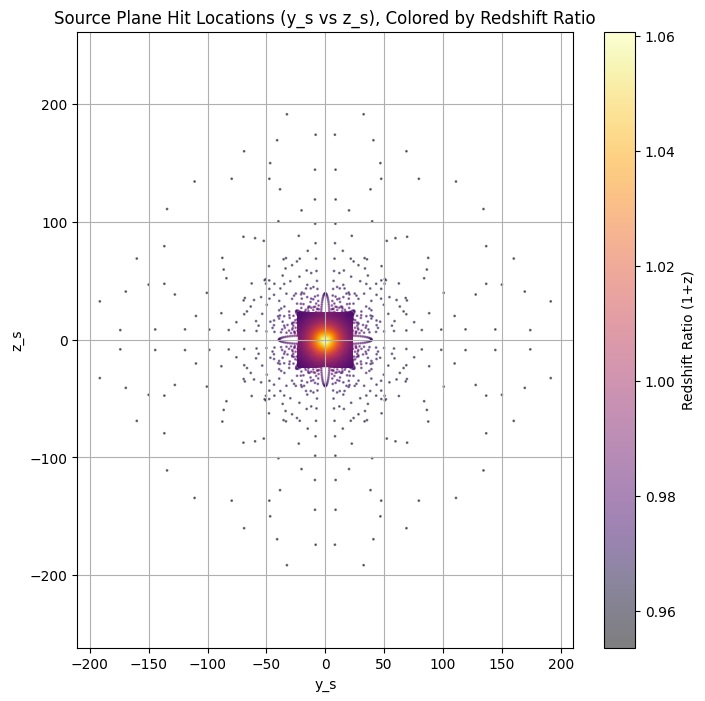

In [34]:
import numpy as np
import os
import matplotlib.pyplot as plt

def inspect_blueprint_file(blueprint_filename="project/photon_geodesic_integrator/blueprint.bin"):
    """
    Reads the binary blueprint file and prints a diagnostic summary.
    This version uses a packed dtype to match the C output.
    """
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # CORRECTED DTYPE: The 'align=True' argument is removed (or set to False) to tell
    # NumPy that the data is tightly packed, exactly matching our new C fwrite pattern.
    blueprint_dtype = np.dtype([
        ('found', '?'),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8')
    ], align=False)
    
    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    
    num_total_rays = len(data)
    # The 'found' flag is now reliable because the data isn't corrupted.
    found_data = data[data['found']]
    num_found_rays = len(found_data)

    print("--- Blueprint File Inspection ---")
    print(f"Total records processed: {num_total_rays}")
    print(f"Valid ray connections found: {num_found_rays} ({100.0 * num_found_rays / num_total_rays:.2f}%)")
    
    if num_found_rays > 0:
        print("\n--- Source Plane Coordinate Statistics ---")
        print(f"  y_s min: {np.min(found_data['y_s']):.3f}, max: {np.max(found_data['y_s']):.3f}")
        print(f"  z_s min: {np.min(found_data['z_s']):.3f}, max: {np.max(found_data['z_s']):.3f}")

        print("\n--- Redshift Ratio Statistics ---")
        print(f"  Ratio min: {np.min(found_data['redshift_ratio']):.3f}, max: {np.max(found_data['redshift_ratio']):.3f}")

        plt.figure(figsize=(8, 8))
        plt.scatter(found_data['y_s'], found_data['z_s'], s=1, alpha=0.5, c=found_data['redshift_ratio'], cmap='inferno')
        plt.title("Source Plane Hit Locations (y_s vs z_s), Colored by Redshift Ratio")
        plt.xlabel("y_s")
        plt.ylabel("z_s")
        plt.colorbar(label="Redshift Ratio (1+z)")
        plt.grid(True)
        plt.axis('equal')
        plt.show()

# Run the inspection
inspect_blueprint_file()

# Markdown for another debugging cell

In [35]:
import numpy as np
import os

def view_binary_blueprint(
    blueprint_filename="project/photon_geodesic_integrator/blueprint.bin",
    max_rays_to_print=50
):
    """
    Reads the binary blueprint file and prints its raw contents in a
    human-readable format. This is a robust debugging tool.
    """
    if not os.path.exists(blueprint_filename):
        print(f"Error: Blueprint file not found at '{blueprint_filename}'")
        return

    # This dtype must exactly match the C struct 'blueprint_data_t'
    blueprint_dtype = np.dtype([
        ('found', '?'),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8')
    ])
    
    data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    
    print(f"--- Raw Blueprint Data Inspector ---")
    print(f"Total records read from file: {len(data)}\n")
    
    print("Printing the first few records...\n")
    # Print a header
    print(f"{'Ray #':<6} | {'Found?':<7} | {'y_w':>10} | {'z_w':>10} | {'y_s':>10} | {'z_s':>10} | {'Redshift':>12}")
    print("-" * 80)

    for i, ray in enumerate(data):
        if i >= max_rays_to_print:
            print(f"\n... and {len(data) - max_rays_to_print} more records.")
            break
            
        # Use a format string that can handle nan and inf gracefully
        print(f"{i:<6} | {str(ray['found']):<7} | "
              f"{ray['y_w']:>10.4f} | {ray['z_w']:>10.4f} | "
              f"{ray['y_s']:>10.4f} | {ray['z_s']:>10.4f} | "
              f"{ray['redshift_ratio']:>12.6f}")

# --- Run the viewer ---
view_binary_blueprint()

--- Raw Blueprint Data Inspector ---
Total records read from file: 262144

Printing the first few records...

Ray #  | Found?  |        y_w |        z_w |        y_s |        z_s |     Redshift
--------------------------------------------------------------------------------
0      | True    |    -0.9908 |    -0.9908 |    22.5201 |   -22.5201 |     0.978580
1      | True    |    -0.9870 |    -0.9909 |    22.4318 |   -22.5200 |     0.978635
2      | True    |    -0.9831 |    -0.9909 |    22.3435 |   -22.5198 |     0.978691
3      | True    |    -0.9793 |    -0.9909 |    22.2552 |   -22.5197 |     0.978746
4      | True    |    -0.9754 |    -0.9909 |    22.1669 |   -22.5195 |     0.978802
5      | True    |    -0.9716 |    -0.9910 |    22.0785 |   -22.5192 |     0.978858
6      | True    |    -0.9677 |    -0.9910 |    21.9902 |   -22.5190 |     0.978913
7      | True    |    -0.9639 |    -0.9910 |    21.9018 |   -22.5187 |     0.978969
8      | True    |    -0.9600 |    -0.9910 |    21.81

# Markdown for testing cell

In [33]:
# Cell ID: (The one defining the Python image renderer) (Final Corrected Version with ROI)

import numpy as np
from PIL import Image
import os

def render_lensed_image_simple(
    source_image_filename,
    output_image_filename,
    output_pixel_width,
    window_physical_width,
    source_physical_width,
    mode='full',
    roi_coords=None
):
    """
    Renders a gravitationally lensed image from a binary blueprint file
    by direct point mapping. Supports both 'full' and 'roi' (Region of Interest) modes.
    """
    # --- 1. Load Data and Set Up Geometry ---
    project_dir = "project"
    project_name = "photon_geodesic_integrator"
    blueprint_filename = os.path.join(project_dir, project_name, "blueprint.bin")

    blueprint_dtype = np.dtype([
        ('found', '?'),
        ('y_w', 'f8'), ('z_w', 'f8'), ('L_w', 'f8'),
        ('y_s', 'f8'), ('z_s', 'f8'), ('L_s', 'f8'),
        ('redshift_ratio', 'f8')
    ], align=False)

    print(f"Loading blueprint from: {blueprint_filename}")
    try:
        blueprint_data = np.fromfile(blueprint_filename, dtype=blueprint_dtype)
    except FileNotFoundError:
        print(f"ERROR: Blueprint file not found at '{blueprint_filename}'.")
        return
    
    blueprint_data = blueprint_data[blueprint_data['found']]
    if len(blueprint_data) == 0:
        print("No valid ray data found in blueprint. Cannot render image.")
        blank_img = Image.fromarray(np.zeros((output_pixel_width, output_pixel_width, 3), dtype=np.uint8))
        blank_img.save(output_image_filename)
        return
        
    print(f"Loading source image from: {source_image_filename}")
    try:
        source_img = Image.open(source_image_filename).convert('RGB')
    except FileNotFoundError:
        print(f"ERROR: Source image not found at '{source_image_filename}'.")
        return

    source_pixel_width, source_pixel_height = source_img.size
    source_pixels = np.array(source_img)

    aspect_ratio = source_pixel_height / float(source_pixel_width)
    output_pixel_height = int(output_pixel_width * aspect_ratio)
    
    window_physical_height = window_physical_width * aspect_ratio
    source_physical_height = float(source_physical_width) * aspect_ratio

    print(f"Output image dimensions: {output_pixel_width} x {output_pixel_height} pixels")

    # --- 2. Initialization and Data Extraction ---
    rgb_sum_accumulator = np.zeros((output_pixel_height, output_pixel_width, 3), dtype=np.float64)
    hit_count_accumulator = np.zeros((output_pixel_height, output_pixel_width), dtype=np.int32)
    
    y_w, z_w = blueprint_data['y_w'], blueprint_data['z_w']
    y_s, z_s = blueprint_data['y_s'], blueprint_data['z_s']

    # --- 3. Processing Loop (with ROI support) ---
    if mode == 'roi':
        if roi_coords is None:
            print("ERROR: Mode is 'roi' but 'roi_coords' not provided.")
            return
        y_min_roi, y_max_roi, z_min_roi, z_max_roi = roi_coords
        # Create a boolean mask to select only the rays within the ROI on the window plane
        roi_mask = (y_w >= y_min_roi) & (y_w <= y_max_roi) & \
                   (z_w >= z_min_roi) & (z_w <= z_max_roi)
        # Apply the mask to all coordinate arrays
        y_w, z_w = y_w[roi_mask], z_w[roi_mask]
        y_s, z_s = y_s[roi_mask], z_s[roi_mask]
        print(f"ROI Mode: Processing {len(y_w)} rays within the specified window region.")

    # Create a mask for rays that hit the physical source area
    source_half_width = source_physical_width / 2.0
    source_half_height = source_physical_height / 2.0
    hit_mask = (np.abs(y_s) <= source_half_width) & (np.abs(z_s) <= source_half_height)
    
    valid_y_w, valid_z_w = y_w[hit_mask], z_w[hit_mask]
    valid_y_s, valid_z_s = y_s[hit_mask], z_s[hit_mask]
    print(f"Found {len(valid_y_w)} rays that hit the source plane area.")
    
    if len(valid_y_w) > 0:
        # --- Convert physical coordinates to pixel indices ---
        window_half_width = window_physical_width / 2.0
        window_half_height = window_physical_height / 2.0
        
        col_out_float = ((valid_y_w + window_half_width) / window_physical_width) * (output_pixel_width - 1)
        row_out_float = ((valid_z_w + window_half_height) / window_physical_height) * (output_pixel_height - 1)
        
        col_src_float = ((valid_y_s + source_half_width) / source_physical_width) * (source_pixel_width - 1)
        row_src_float = ((valid_z_s + source_half_height) / source_physical_height) * (source_pixel_height - 1)

        col_out = np.clip(col_out_float, 0, output_pixel_width - 1).astype(int)
        row_out = np.clip(row_out_float, 0, output_pixel_height - 1).astype(int)
        
        col_src = np.clip(col_src_float, 0, source_pixel_width - 1).astype(int)
        row_src = np.clip(row_src_float, 0, source_pixel_height - 1).astype(int)

        source_colors = source_pixels[row_src, col_src]

        # --- Accumulate data ---
        np.add.at(rgb_sum_accumulator, (row_out, col_out), source_colors)
        np.add.at(hit_count_accumulator, (row_out, col_out), 1)

    # --- 4. Final Image Construction ---
    print("Averaging colors and constructing final image...")
    hit_pixels_mask = hit_count_accumulator > 0
    output_pixels = np.zeros_like(rgb_sum_accumulator, dtype=np.uint8)
    
    avg_colors = rgb_sum_accumulator[hit_pixels_mask] / hit_count_accumulator[hit_pixels_mask][:, np.newaxis]
    output_pixels[hit_pixels_mask] = np.clip(np.round(avg_colors), 0, 255).astype(np.uint8)

    # --- 5. Save the final image ---
    final_image = Image.fromarray(output_pixels)
    final_image.save(output_image_filename)
    print(f"Successfully rendered and saved lensed image to '{output_image_filename}'")


# --- Example Usage ---
if not os.path.exists('rainbow.png'):
    print("Creating a dummy 'rainbow.png' for testing.")
    height, width = 512, 512
    img_array = np.zeros((height, width, 3), dtype=np.uint8)
    colors = [(255,0,0), (255,127,0), (255,255,0), (0,255,0), (0,0,255), (75,0,130), (148,0,211)]
    band_height = height // len(colors)
    for i, color in enumerate(colors):
        img_array[i*band_height:(i+1)*band_height, :] = color
    Image.fromarray(img_array).save('rainbow.png')

# --- RENDER IN FULL MODE ---
render_lensed_image_simple(
    source_image_filename='rainbow.png',
    output_image_filename='kerr_lensed_simple_full.png',
    output_pixel_width=400,
    window_physical_width=2.0, 
    source_physical_width=40.0,
    mode='full'
)

# --- RENDER IN ROI MODE (zoom into the center) ---
render_lensed_image_simple(
    source_image_filename='rainbow.png',
    output_image_filename='kerr_lensed_simple_roi.png',
    output_pixel_width=400,
    window_physical_width=2.0,
    source_physical_width=40.0,
    mode='roi',
    roi_coords=(-2.0, 2.0, -2.0, 2.0) # A small box around the center of the window
)

Loading blueprint from: project/photon_geodesic_integrator/blueprint.bin
Loading source image from: rainbow.png
Output image dimensions: 400 x 266 pixels
Found 133224 rays that hit the source plane area.
Averaging colors and constructing final image...
Successfully rendered and saved lensed image to 'kerr_lensed_simple_full.png'
Loading blueprint from: project/photon_geodesic_integrator/blueprint.bin
Loading source image from: rainbow.png
Output image dimensions: 400 x 266 pixels
ROI Mode: Processing 244756 rays within the specified window region.
Found 133224 rays that hit the source plane area.


/home/daltonm/Documents/venv/lib/python3.13/site-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Averaging colors and constructing final image...
Successfully rendered and saved lensed image to 'kerr_lensed_simple_roi.png'
